# Model Training: Jail Population Time Series Analysis

The purpose of this notebook will be to get a better sense for the seasonality and autocorrelation in time series data of the jail population. In the notebook `01_get_data.ipynb`, we aggregated the daily population of people in NYC DOC custody to 7 day and 30 day averages. We will therefore decompose the daily, weekly, and monthly signals to get a better understanding for the components of the signal: trend, seasonality, residuals.

Once we have determined which signal to use for our model, we will introduce exogenous variables to see whether or not the model performance increases. The exogenous variables will include major policy interventions, DOC, and PD data. See script `02_a_exog_vars_ts_analysis_30day.ipynb` and `02_b_exog_vars_ts_analysis_7day.ipynb` for more information on the DOC and PD exogenous variables aggregated to 30-day and 7-day periods, respectively.

**DISCLAIMER:** We are NOT going to use the daily data due to bandwidth limitations. We have commented these sections out and will mainly work with weekly and monthly aggregated signals.

In [1]:
#import packages needed
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

In [2]:
#import data
daily_pop = pd.read_csv("../Data/daily_pop.csv", index_col=0)
weekly_pop = pd.read_csv("../Data/_7_day_adp.csv", index_col=0)
monthly_pop = pd.read_csv("../Data/_30_day_adp.csv", index_col=0)
daily_pop.head()

,snapshot_date,Total Population
0,2016-06-02,9836
1,2016-06-03,9780
2,2016-06-04,9765
3,2016-06-05,9894
4,2016-06-06,9904


In [3]:
weekly_pop.head()

,Start Date,End Date,ADP
0,2016-06-01,2016-06-07,9834.0
1,2016-06-08,2016-06-14,9809.0
2,2016-06-15,2016-06-21,9792.0
3,2016-06-22,2016-06-28,9818.0
4,2016-06-29,2016-07-05,9809.0


In [4]:
monthly_pop.head()

,Start Date,End Date,ADP
0,2016-05-23,2016-06-21,9811.0
1,2016-06-22,2016-07-21,9772.0
2,2016-07-22,2016-08-20,9749.0
3,2016-08-21,2016-09-19,9860.0
4,2016-09-20,2016-10-19,9821.0


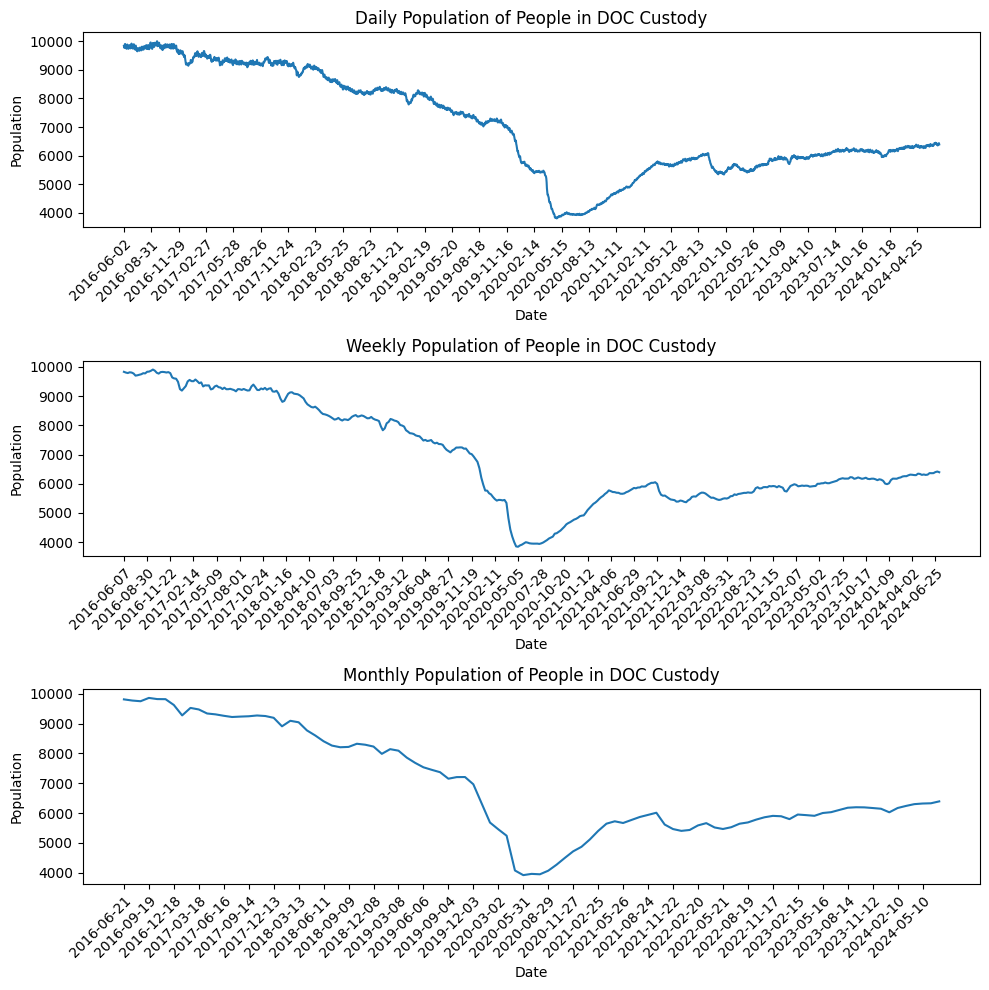

In [5]:
#plot the three series on top of one another
# Create a figure and subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].plot(daily_pop['snapshot_date'], daily_pop['Total Population'])
ax[0].set_title('Daily Population of People in DOC Custody')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Population')
ax[0].set_xticks(daily_pop['snapshot_date'][::90]) 
ax[0].set_xticklabels(daily_pop['snapshot_date'][::90], rotation=45, ha="right",rotation_mode="anchor")  # Set the xtick labels with rotation

ax[1].plot(weekly_pop['End Date'], weekly_pop['ADP'])
ax[1].set_title('Weekly Population of People in DOC Custody')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Population')
ax[1].set_xticks(weekly_pop['End Date'][::12]) 
ax[1].set_xticklabels(weekly_pop['End Date'][::12], rotation=45, ha="right",rotation_mode="anchor")  # Set the xtick labels with rotation

ax[2].plot(monthly_pop['End Date'], monthly_pop['ADP'])
ax[2].set_title('Monthly Population of People in DOC Custody')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Population')
ax[2].set_xticks(monthly_pop['End Date'][::3])
ax[2].set_xticklabels(monthly_pop['End Date'][::3], rotation=45, ha="right",rotation_mode="anchor")  # Set the xtick labels with rotation


# Adjust layout
plt.tight_layout()
plt.show()

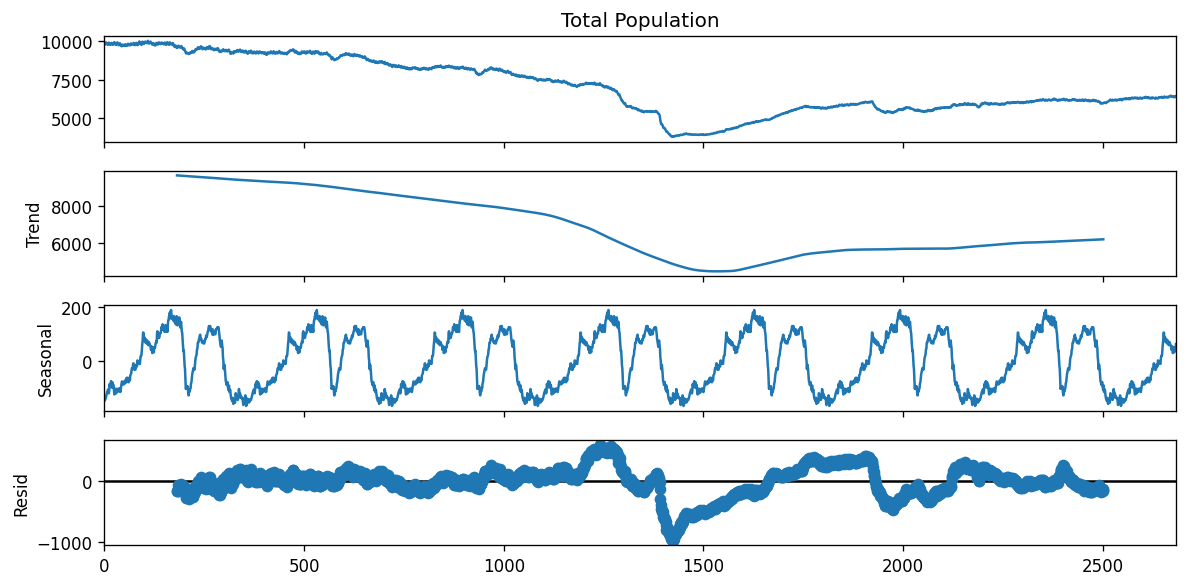

In [6]:
#decompose
results = seasonal_decompose(daily_pop['Total Population'],model='additive',period=365)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

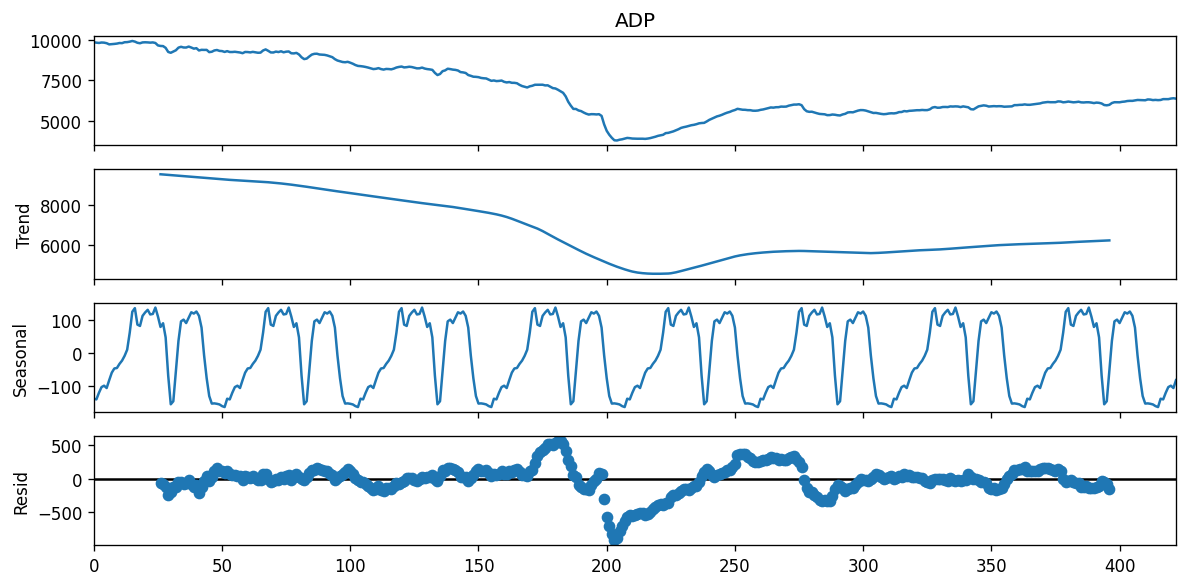

In [7]:
#decompose
results = seasonal_decompose(weekly_pop['ADP'],model='additive',period=52)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

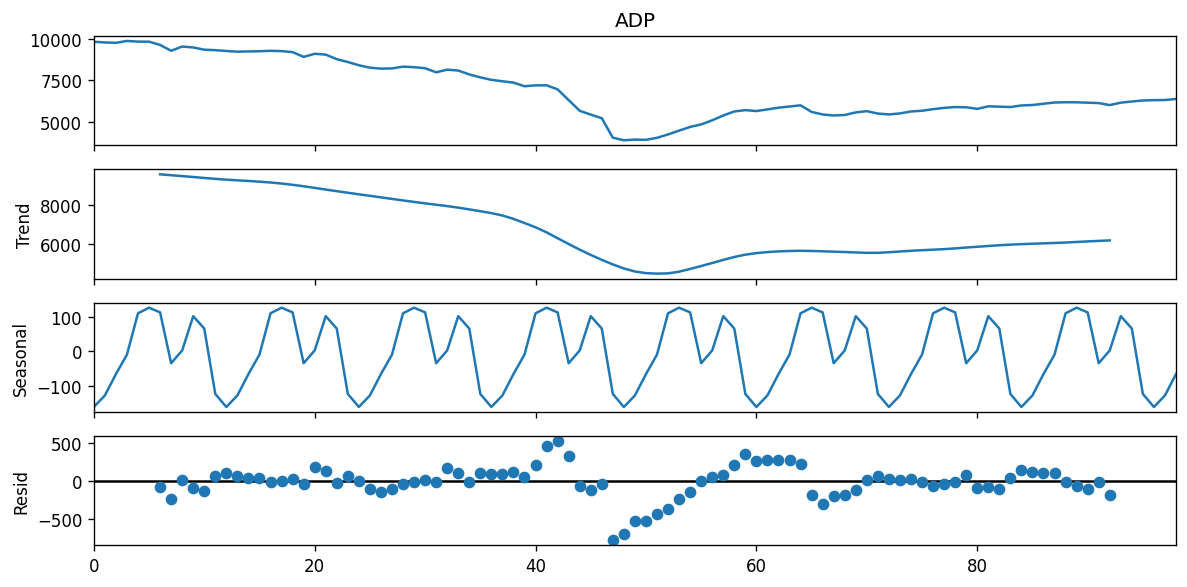

In [8]:
#decompose
results = seasonal_decompose(monthly_pop['ADP'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

Let's figure out the differencing degree on these signals. ARIMA models require a signal is stationary. This means the signal has consistent statistical properties over time such as constant mean, constant variance, and auto-covariance not depending on time. Stationarity can be achieved in many ways like differencing, logarithmic transformation, or decomposition. I will first attempt to make our signals stationary using differencing. To test if the result is stationary, I will conduct an augmented Dickey-Fuller (ADF) test and also plot the auto-correlation of the differences signal. You can check stationarity with the Autocorrelation Function (ACF) plot. If ACF decreases quickly, it suggests stationarity; a slow decline indicates non-stationarity.

In [21]:
result = adfuller(daily_pop['Total Population'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(daily_pop['Total Population'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(daily_pop['Total Population'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.591780
p-value: 0.487721
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -6.726652
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -17.181277
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


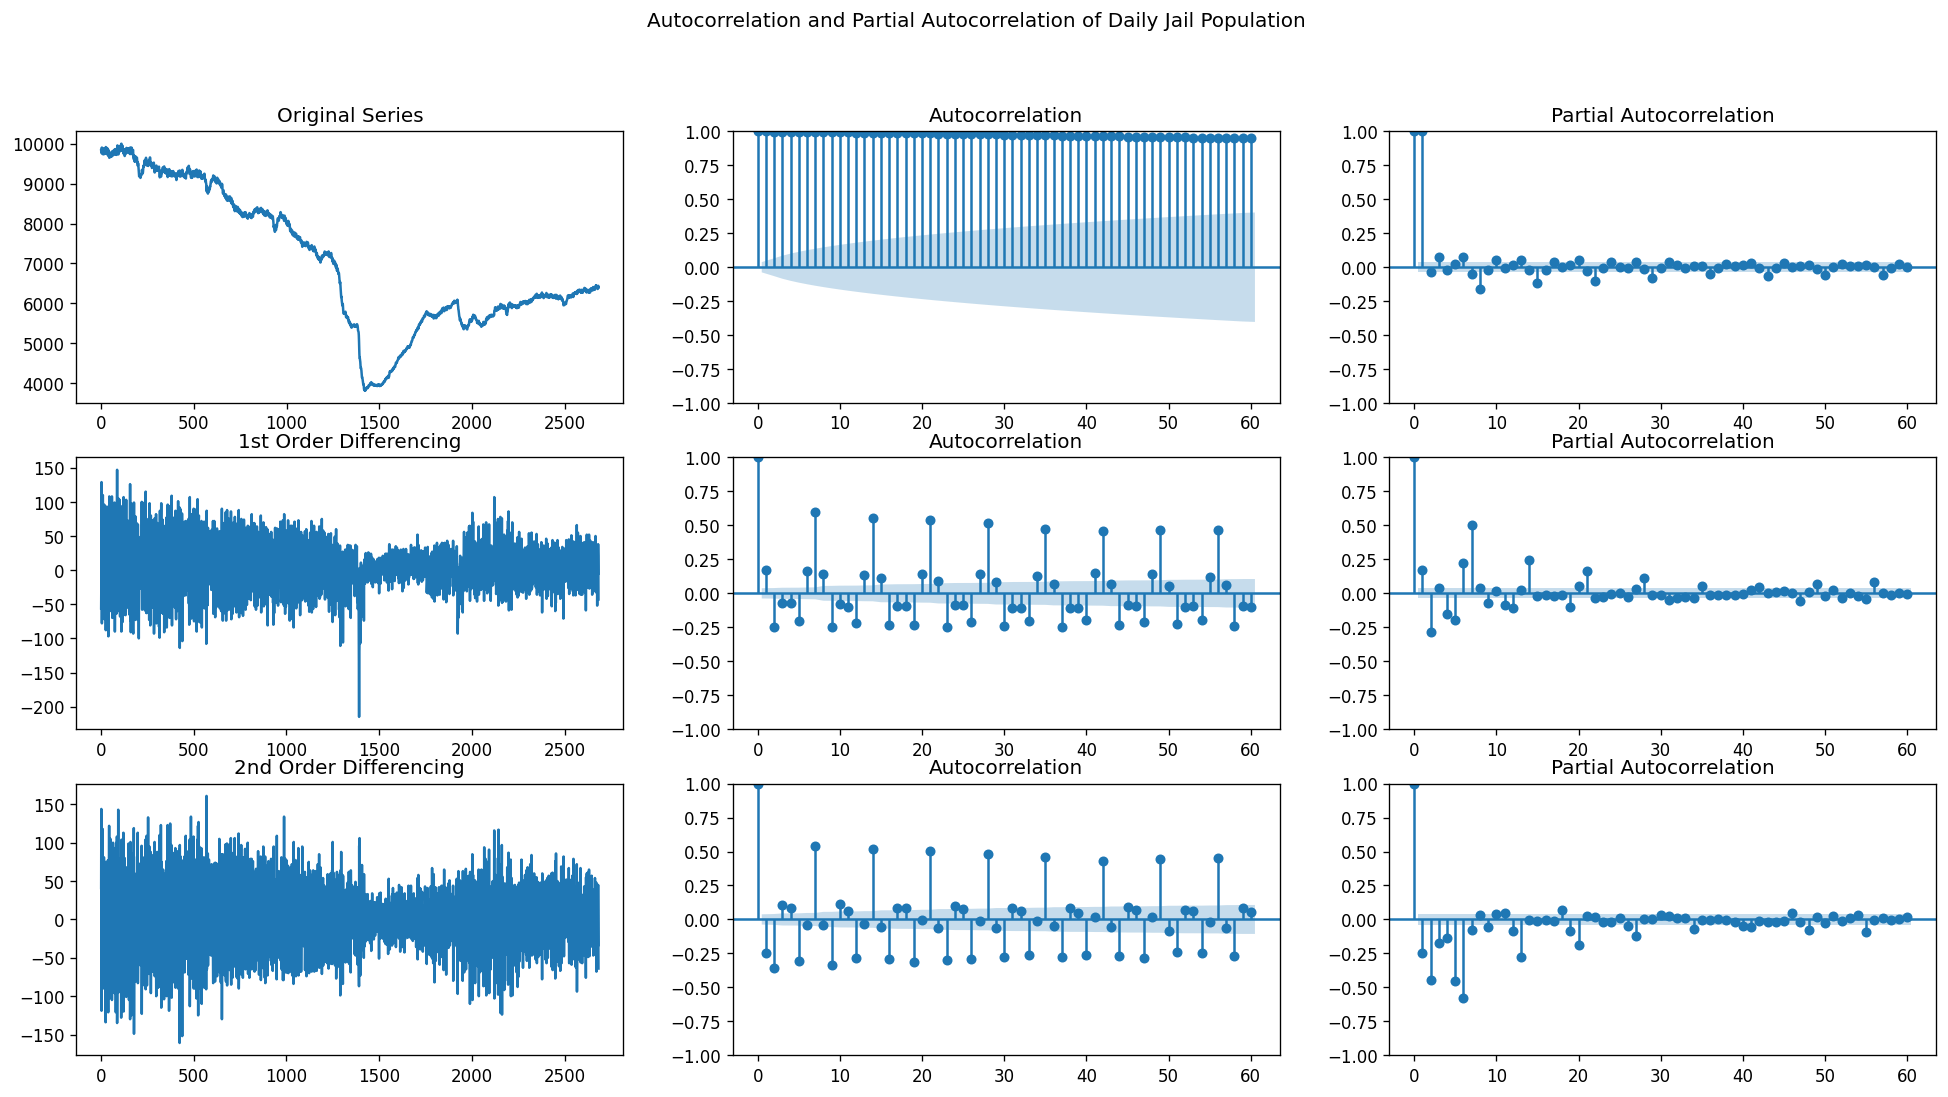

In [22]:
#based on the ADF test above, d = 1. Let's plot the acf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(daily_pop['Total Population']); axes[0, 0].set_title('Original Series')

plot_acf(daily_pop['Total Population'], lags = 60, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(daily_pop['Total Population'], lags = 60, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(daily_pop['Total Population'].diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(daily_pop['Total Population'].diff().dropna(), lags = 60, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(daily_pop['Total Population'].diff().dropna(), lags = 60, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(daily_pop['Total Population'].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')

plot_acf(daily_pop['Total Population'].diff().diff().dropna(), lags = 60, ax = axes[2, 1])
axes[2, 1].set_title('Autocorrelation')

plot_pacf(daily_pop['Total Population'].diff().diff().dropna(), lags = 60, ax=axes[2, 2])
axes[2, 2].set_title('Partial Autocorrelation')

fig.suptitle("Autocorrelation and Partial Autocorrelation of Daily Jail Population")
plt.savefig("../Outputs/daily_jail_pop_acf_pacf_plots.png",bbox_inches = 'tight')
plt.show()

In [20]:
result = adfuller(weekly_pop['ADP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(weekly_pop['ADP'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(weekly_pop['ADP'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.932235
p-value: 0.317052
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
ADF Statistic: -3.788761
p-value: 0.003024
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
ADF Statistic: -10.072735
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


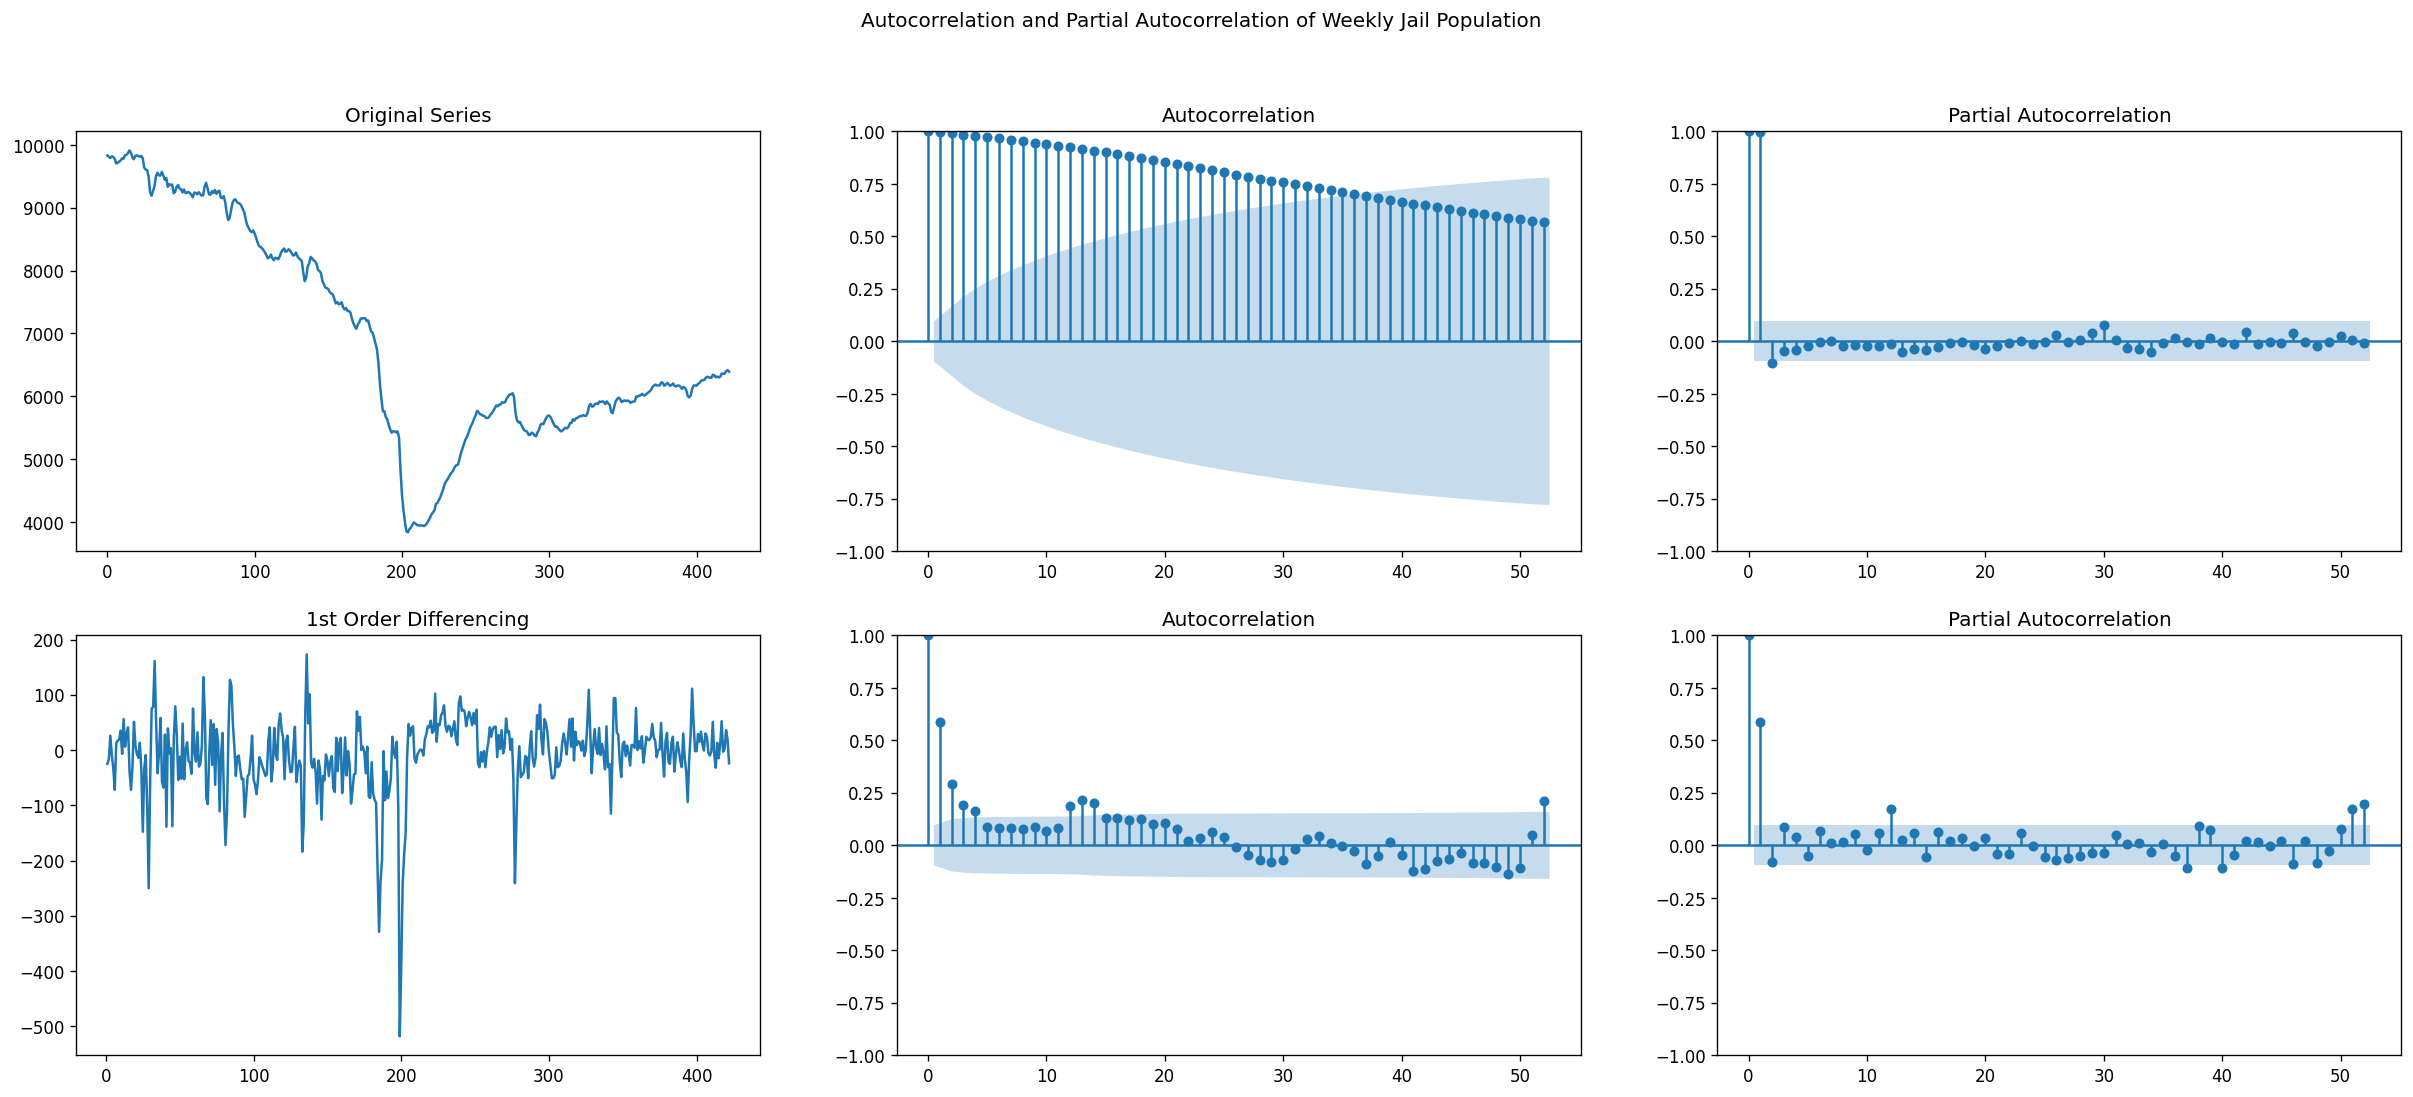

In [12]:
#based on the ADF test above, d = 1. Let's plot the acf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(25,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(weekly_pop['ADP']); axes[0, 0].set_title('Original Series')

plot_acf(weekly_pop['ADP'], lags = 52, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(weekly_pop['ADP'], lags = 52, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(weekly_pop['ADP'].diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(weekly_pop['ADP'].diff().dropna(), lags = 52, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(weekly_pop['ADP'].diff().dropna(), lags = 52, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

fig.suptitle("Autocorrelation and Partial Autocorrelation of Weekly Jail Population")
plt.savefig("../Outputs/weekly_jail_pop_acf_pacf_plots.png",bbox_inches = 'tight')

plt.show()

Based on the ADF results and the plots above, the weekly differenced signal seems stationary. 

In [18]:
result = adfuller(monthly_pop['ADP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(monthly_pop['ADP'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(monthly_pop['ADP'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.009138
p-value: 0.282581
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
ADF Statistic: -3.349982
p-value: 0.012787
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
ADF Statistic: -8.623265
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


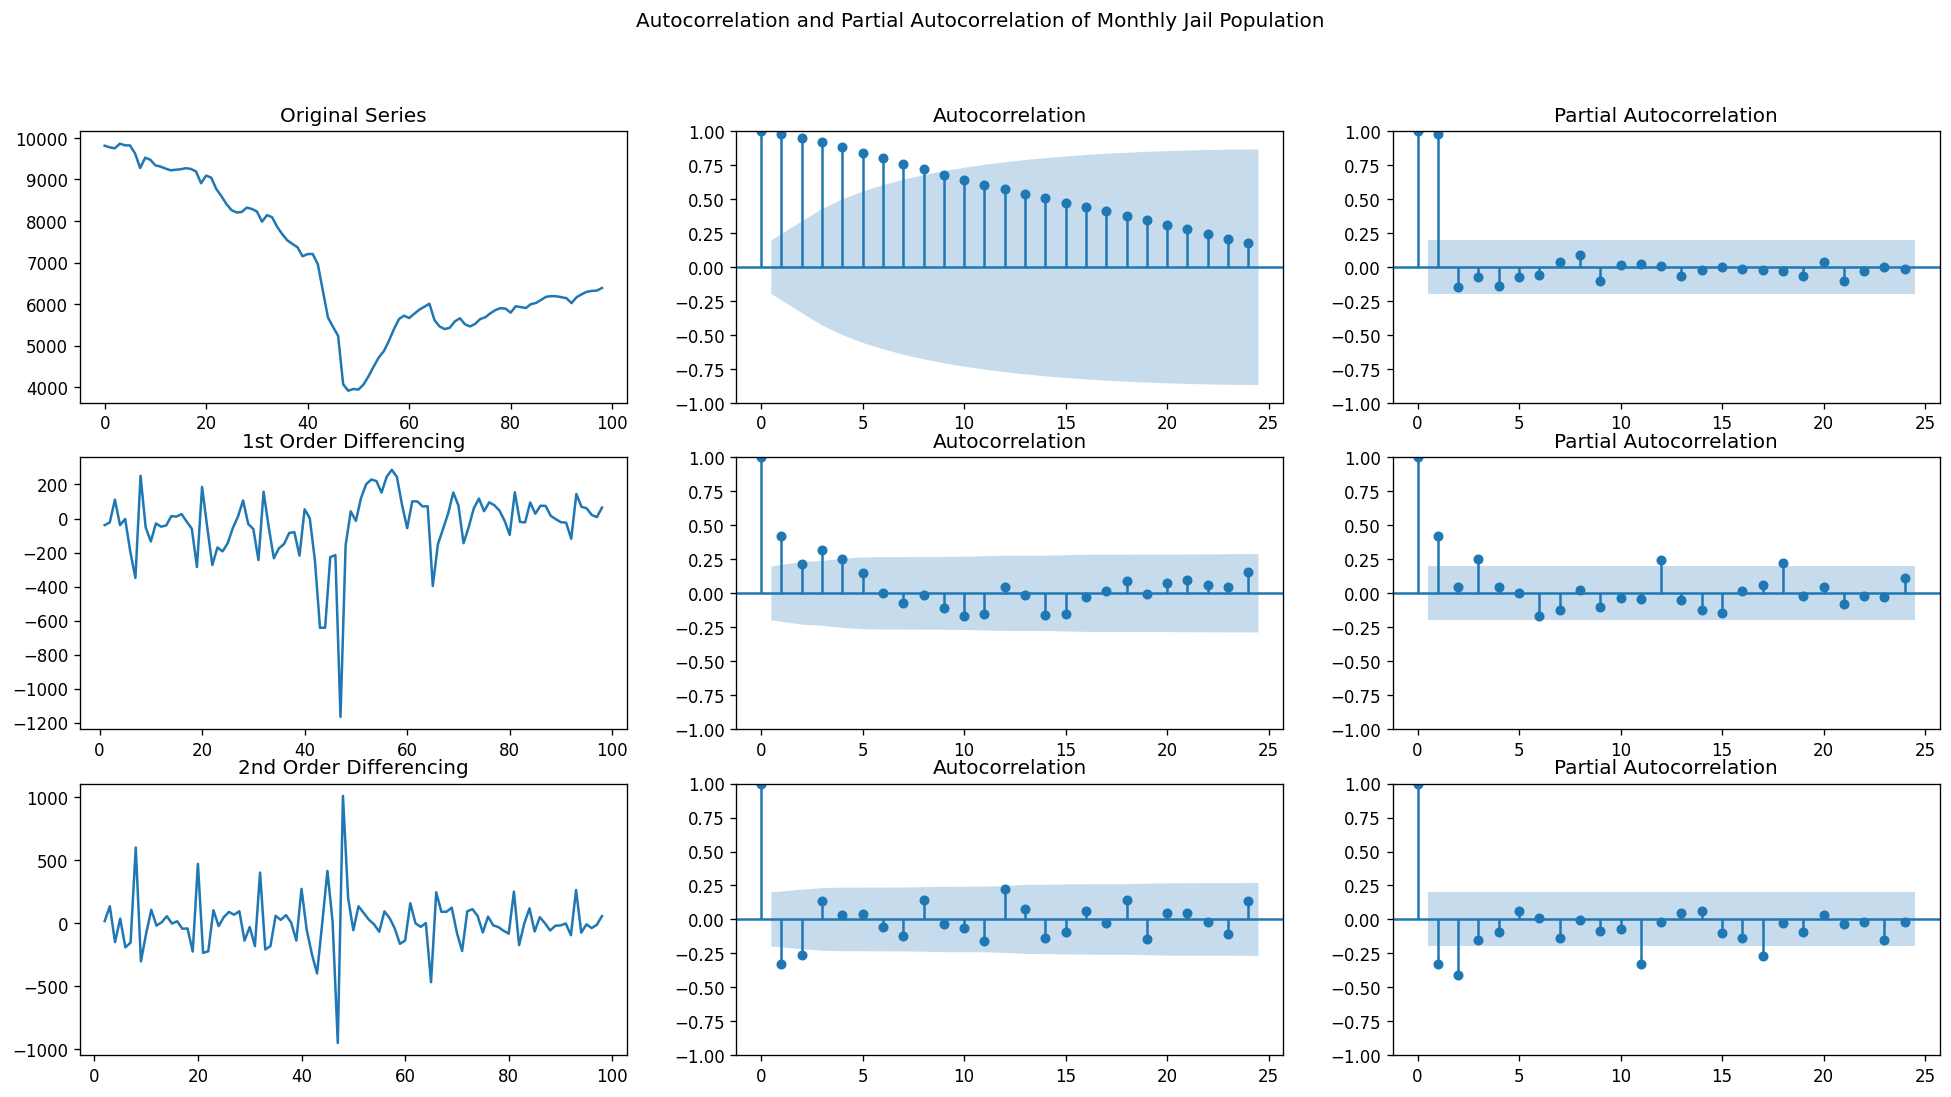

In [19]:
#based on the ADF test above, d = 1. Let's plot the acf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(monthly_pop['ADP']); axes[0, 0].set_title('Original Series')

plot_acf(monthly_pop['ADP'], lags = 24, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(monthly_pop['ADP'], lags = 24, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(monthly_pop['ADP'].diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(monthly_pop['ADP'].diff().dropna(), lags = 24, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(monthly_pop['ADP'].diff().dropna(), lags = 24, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(monthly_pop['ADP'].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')

plot_acf(monthly_pop['ADP'].diff().diff().dropna(), lags = 24, ax = axes[2, 1])
axes[2, 1].set_title('Autocorrelation')

plot_pacf(monthly_pop['ADP'].diff().diff().dropna(), lags = 24, ax=axes[2, 2])
axes[2, 2].set_title('Partial Autocorrelation')

fig.suptitle("Autocorrelation and Partial Autocorrelation of Monthly Jail Population")
plt.savefig("../Outputs/monthly_jail_pop_acf_pacf_plots.png",bbox_inches = 'tight')
plt.show()

Let's fit each signal to using autoarima package and predict 1 year into the future. This is just a diagnostic to see which coefficients for the autoregressive, moving-average, and differencing terms are.

In [23]:
print(f'The optimal d coefficient for the daily signal with alpha = 0.05 is: ', ndiffs(daily_pop['Total Population'], test='adf'))
print(f'The optimal d coefficient for the weekly signal with alpha = 0.05 is: ', ndiffs(weekly_pop['ADP'], test='adf'))
print(f'The optimal d coefficient for the monthly signal with alpha = 0.05 is: ', ndiffs(monthly_pop['ADP'], test='adf'))

The optimal d coefficient for the daily signal with alpha = 0.05 is:  1
The optimal d coefficient for the weekly signal with alpha = 0.05 is:  1
The optimal d coefficient for the monthly signal with alpha = 0.05 is:  2


In [24]:
print(f'The optimal d coefficient for the daily signal with alpha = 0.025 is: ', ndiffs(daily_pop['Total Population'], test='adf', alpha = 0.025))
print(f'The optimal d coefficient for the weekly signal with alpha = 0.025 is: ', ndiffs(weekly_pop['ADP'], test='adf', alpha = 0.025))
print(f'The optimal d coefficient for the monthly signal with alpha = 0.025 is: ', ndiffs(monthly_pop['ADP'], test='adf', alpha = 0.025))

The optimal d coefficient for the daily signal with alpha = 0.025 is:  1
The optimal d coefficient for the weekly signal with alpha = 0.025 is:  1
The optimal d coefficient for the monthly signal with alpha = 0.025 is:  2


In [25]:
# # Fit a simple auto_arima model
# auto_arima = pm.auto_arima(daily_pop['Total Population'], error_action='ignore', trace=True,
#                       suppress_warnings=True, maxiter=5,
#                       seasonal=True, m=365)
# #in sample
# in_sample = auto_arima.predict_in_sample()
# # Create predictions for the future, evaluate on test
# preds, conf_int = auto_arima.predict(n_periods=365, return_conf_int=True)

# #plot
# plt.plot(daily_pop.index,daily_pop['Total Population'],'bo-', label = 'Daily Jail Population')
# plt.plot(daily_pop.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
# plt.plot(np.arange(len(daily_pop),len(daily_pop)+365), preds,'ro-',label = 'forecast')  # Forecasts
# plt.fill_between(np.arange(len(daily_pop),len(daily_pop)+365),
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='grey')
# plt.legend(loc = 'lower right')
# plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Daily Jail Population")
# plt.show()

In [26]:
# # Fit a simple auto_arima model
# auto_arima = pm.auto_arima(weekly_pop['ADP'], error_action='ignore', trace=True,
#                       suppress_warnings=True, d = ndiffs(weekly_pop['ADP'], test='adf'), maxiter=5,
#                       seasonal=True, m=52)
# #in sample
# in_sample = auto_arima.predict_in_sample()
# # Create predictions for the future, evaluate on test
# preds, conf_int = auto_arima.predict(n_periods=52, return_conf_int=True)

# #plot
# plt.plot(weekly_pop.index,weekly_pop['ADP'],'bo-', label = 'Daily Jail Population')
# plt.plot(weekly_pop.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
# plt.plot(np.arange(len(weekly_pop),len(weekly_pop)+52), preds,'ro-',label = 'forecast')  # Forecasts
# plt.fill_between(np.arange(len(weekly_pop),len(weekly_pop)+52),
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='grey')
# plt.legend(loc = 'lower right')
# plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Weekly Average Jail Population")
# plt.show()

In [27]:
#print(auto_arima.summary())

In [28]:
#let's look at the final prediction
# print(preds.iloc[-1].round(), conf_int[-1])

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1296.466, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1318.839, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1306.816, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1295.805, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1296.159, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1296.242, Time=0.11 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1296.088, Time=0.23 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1295.099, Time=0.10 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1295.595, Time=0.26 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1297.683, Time=0.30 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1315.745, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1296.281, Time=0.16 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1294.921, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1294.467, Time=0.05 sec
 ARIMA(0,2,2)(0,0,1

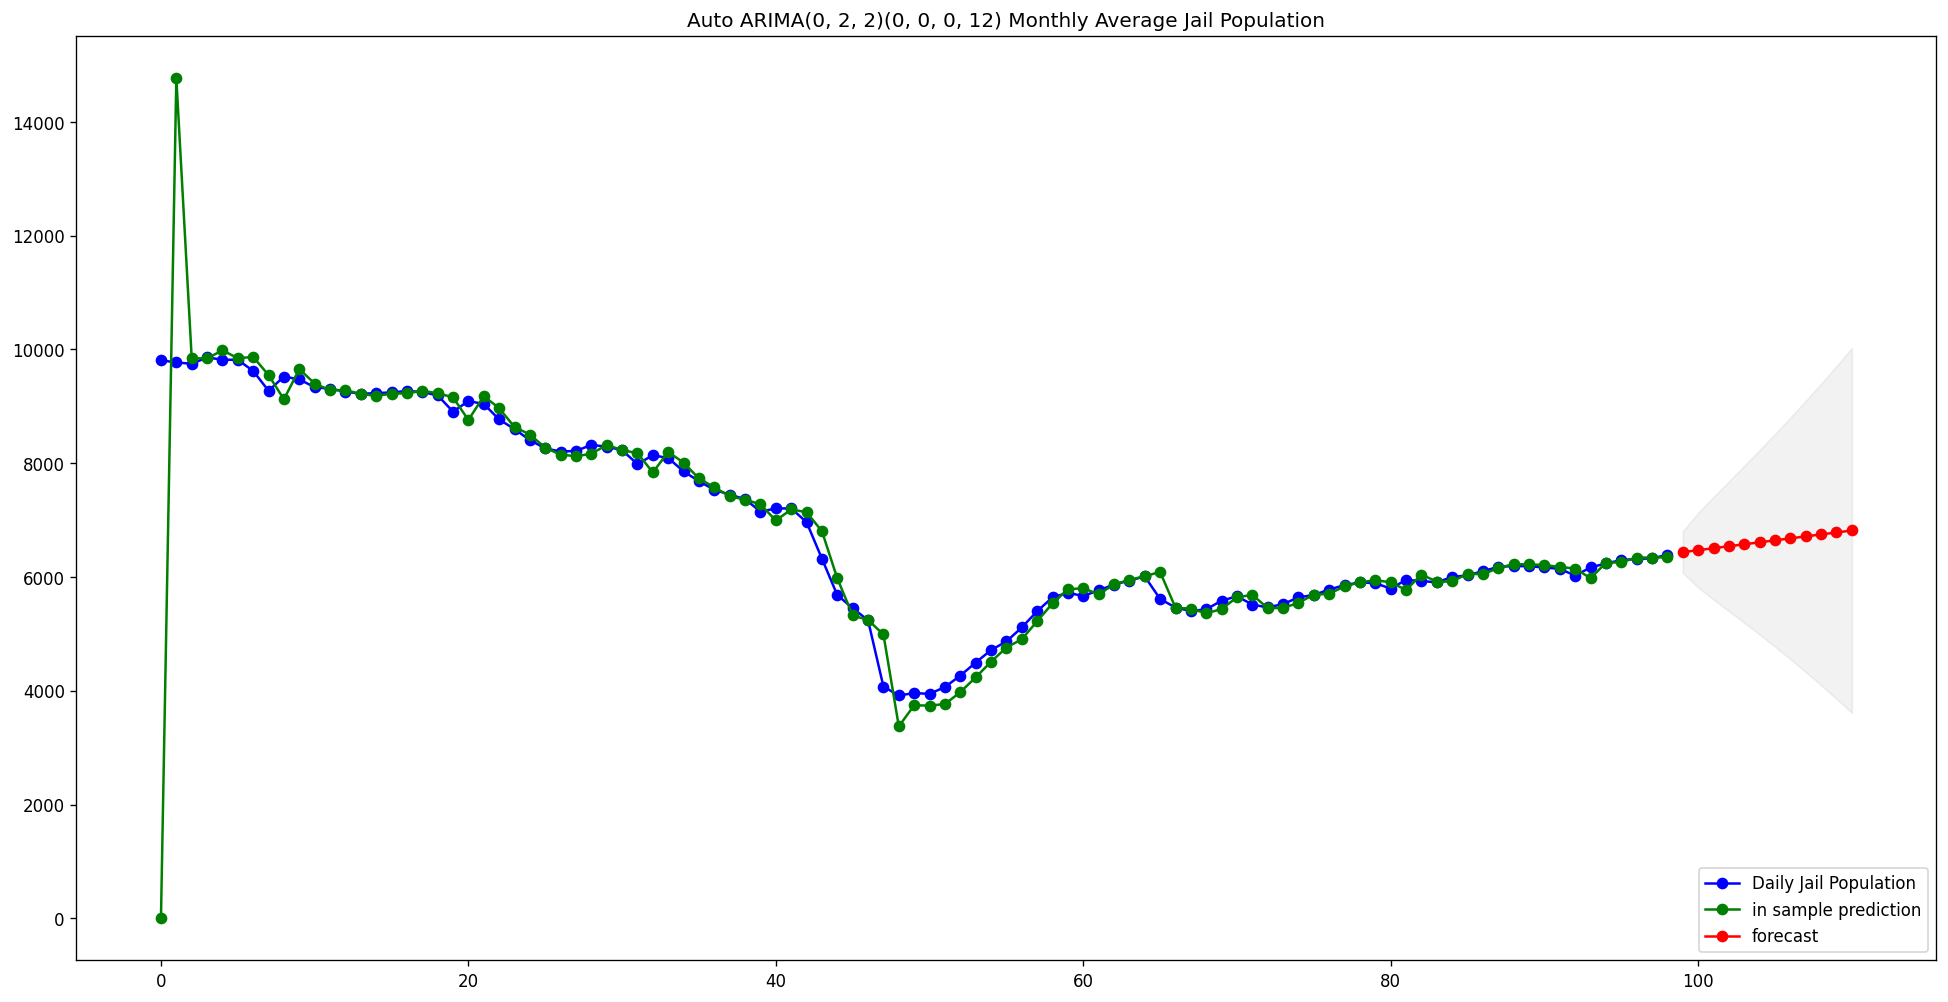

In [29]:
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(monthly_pop['ADP'], error_action='ignore', trace=True,
                      suppress_warnings=True, d = ndiffs(monthly_pop['ADP'], test='adf'), maxiter=5,
                      seasonal=True, m=12)
#in sample
in_sample = auto_arima.predict_in_sample()
# Create predictions for the future, evaluate on test
preds, conf_int = auto_arima.predict(n_periods=12, return_conf_int=True)

#plot
plt.plot(monthly_pop.index,monthly_pop['ADP'],'bo-', label = 'Daily Jail Population')
plt.plot(monthly_pop.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(monthly_pop),len(monthly_pop)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(monthly_pop),len(monthly_pop)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Monthly Average Jail Population")
plt.show()

In [30]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -644.234
Date:                Wed, 10 Jul 2024   AIC                           1294.467
Time:                        20:13:18   BIC                           1302.192
Sample:                             0   HQIC                          1297.591
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5071      0.061     -8.269      0.000      -0.627      -0.387
ma.L2         -0.2819      0.097     -2.902      0.004      -0.472      -0.092
sigma2      3.464e+04   2720.574     12.733      0.0

In [31]:
#let's look at the final prediction
print(preds.iloc[-1].round(), conf_int[-1])

6818.0 [ 3610.99650986 10025.27629378]


## Now let's incorporate exogenous variables into our model

I think either weekly or monthly resampled data will be sufficient for predicting next year's jail population. Let's create exogenous variables for some key events that impacted the jail population during this sample and see how it impacts our outputs. Some key events include:

* COVID-19 Pandemic (Emergency EO 435): [March 12, 2020 - June 19, 2023](https://www.nyc.gov/office-of-the-mayor/news/435-003/emergency-executive-order-435)

* Mayoral Administrations (de Blasio and Adams): 2014 to 2022 and 2022 - current day, respectively

* Less is More Act: [Went into full effect on March 1, 2022](https://legalaidnyc.org/get-help/parole/what-you-need-to-know-about-the-less-is-more-act/) 

* Bail Reform: [January 2020](https://www.brennancenter.org/our-work/research-reports/facts-bail-reform-new-york-how-pretrial-detention-and-release-works-now?_nhids=%25recipient.hids%25&_nlid=gaEtxw2Pxw#:~:text=In%202019%2C%20New%20York%20ended,the%20default%20in%20these%20cases.)

* Raise the Age: [RTA changed the age of criminal responsibility to: 17, as of October 1, 2018 and 18, as of October 1, 2019](https://www.nycourts.gov/courthelp/criminal/RTA.shtml).

Initial bail reform implementation: could be 01/01/20 or it could be a month or two before the actual passing of the bill. This is defensible because judges began implementing bail changes preemptively. We are going to use 12/01/2019 as the bail reform intervention date as this what when judges in NYC began implementing.

**Bail reform roll backs:** the first roll back occured on 07/02/2020. This would most likely be the rollback with the most effect but I think I will be backed into the over all bail reform event intervention flag. 

In [32]:
#create event flag based on the daily pop index, then we will redefine for week and month
# Define key event dates
covid_start_date = pd.to_datetime('2020-03-12')
covid_end_date = pd.to_datetime('2023-06-19')
less_is_more_date = pd.to_datetime('2022-03-01')
bail_reform_date = pd.to_datetime('2019-12-01')
raise_the_age_17_date = pd.to_datetime('2018-10-01')
raise_the_age_18_date = pd.to_datetime('2019-10-01')
de_blasio_admin = pd.to_datetime('2014-01-01')
adams_admin = pd.to_datetime('2022-01-01')

# Convert 'snapshot_date' to datetime format
daily_pop['snapshot_date'] = pd.to_datetime(daily_pop['snapshot_date'])

# Create binary variables for key events
daily_pop['covid_event'] = ((daily_pop.snapshot_date >= covid_start_date) & (daily_pop.snapshot_date <= covid_end_date)).astype(int)
daily_pop['less_is_more_event'] = (daily_pop.snapshot_date >= less_is_more_date).astype(int)
daily_pop['bail_reform_event'] = (daily_pop.snapshot_date >= bail_reform_date).astype(int)
daily_pop['raise_the_age_17_event'] = (daily_pop.snapshot_date >= raise_the_age_17_date).astype(int)
daily_pop['raise_the_age_18_event'] = (daily_pop.snapshot_date >= raise_the_age_18_date).astype(int)
daily_pop['de_blasio_admin'] = ((daily_pop.snapshot_date >= de_blasio_admin) & (daily_pop.snapshot_date < adams_admin)).astype(int)
daily_pop['adams_admin'] = (daily_pop.snapshot_date >= adams_admin).astype(int)

# Check the dataframe with added event columns
daily_pop.head()

,snapshot_date,Total Population,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin
0,2016-06-02,9836,0,0,0,0,0,1,0
1,2016-06-03,9780,0,0,0,0,0,1,0
2,2016-06-04,9765,0,0,0,0,0,1,0
3,2016-06-05,9894,0,0,0,0,0,1,0
4,2016-06-06,9904,0,0,0,0,0,1,0


In [33]:
# Resample daily data to weekly, aggregating 'ADP' with mean and event flags with max
#get latest snapshot date
max_date = daily_pop['snapshot_date'].max()

weekly_pop = daily_pop.resample('7D',on='snapshot_date',origin = max_date,closed='right',label = 'right').agg({
    'Total Population': 'mean',
    'covid_event': 'max',
    'less_is_more_event': 'max',
    'bail_reform_event': 'max',
    'raise_the_age_17_event': 'max',
    'raise_the_age_18_event': 'max',
    'de_blasio_admin':'max',
    'adams_admin':'max'
}).round().fillna(0).reset_index()

# Rename the 'index' column to 'Start Date'
weekly_pop = weekly_pop.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
weekly_pop['Start Date'] = weekly_pop['End Date'] - pd.to_timedelta(6, unit='D')

#interpolate adp values where they are zero
weekly_pop["ADP"] = weekly_pop["ADP"].replace(0,np.nan)
weekly_pop["ADP"] = weekly_pop["ADP"].interpolate(method='linear', axis=0).ffill().bfill()

weekly_pop.head()

,End Date,ADP,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin,Start Date
0,2016-06-07,9834.0,0,0,0,0,0,1,0,2016-06-01
1,2016-06-14,9809.0,0,0,0,0,0,1,0,2016-06-08
2,2016-06-21,9792.0,0,0,0,0,0,1,0,2016-06-15
3,2016-06-28,9818.0,0,0,0,0,0,1,0,2016-06-22
4,2016-07-05,9809.0,0,0,0,0,0,1,0,2016-06-29


In [34]:
weekly_pop.dtypes

End Date                  datetime64[ns]
ADP                              float64
covid_event                        int32
less_is_more_event                 int32
bail_reform_event                  int32
raise_the_age_17_event             int32
raise_the_age_18_event             int32
de_blasio_admin                    int32
adams_admin                        int32
Start Date                datetime64[ns]
dtype: object

In [35]:
#aggregate to monthly
monthly_pop = daily_pop.resample('30D',on='snapshot_date',origin = max_date,closed='right',label = 'right').agg({
    'Total Population': 'mean',
    'covid_event': 'max',
    'less_is_more_event': 'max',
    'bail_reform_event': 'max',
    'raise_the_age_17_event': 'max',
    'raise_the_age_18_event': 'max',
    'de_blasio_admin':'max',
    'adams_admin':'max'
}).round().fillna(0).reset_index()

# Rename the 'index' column to 'Start Date'
monthly_pop = monthly_pop.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
monthly_pop['Start Date'] = monthly_pop['End Date'] - pd.to_timedelta(29, unit='D')

monthly_pop.head()

,End Date,ADP,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin,Start Date
0,2016-06-21,9811.0,0,0,0,0,0,1,0,2016-05-23
1,2016-07-21,9772.0,0,0,0,0,0,1,0,2016-06-22
2,2016-08-20,9749.0,0,0,0,0,0,1,0,2016-07-22
3,2016-09-19,9860.0,0,0,0,0,0,1,0,2016-08-21
4,2016-10-19,9821.0,0,0,0,0,0,1,0,2016-09-20


We also want to include the exogenous variables from DOC and NYPD sources that we analyzed in `02_c_exog_vars_ts_analysis_funnel_model.ipynb`. Lets import the data.

In [36]:
#import the dictionary and use the key to get the order and seasonal order 
# Opening JSON file
with open("../Data/30_day_exog_ARIMA_models.json") as json_file:
    arima_dict = json.load(json_file)

print(arima_dict['admission_count'])

{'order': [1, 1, 0], 'seasonal_order': [1, 0, 0, 12], 'IS_MEA': 218.28, 'adjusted y': [4800.0, 4857.0, 4798.0, 4687.0, 4590.0, 4669.0, 4124.0, 4008.0, 4869.0, 4469.0, 4842.0, 4815.0, 4740.0, 4430.0, 4659.0, 4331.0, 4333.0, 4229.0, 4084.0, 3394.0, 4112.0, 3618.0, 3735.0, 3813.0, 3544.0, 3579.0, 3623.0, 3305.0, 3311.0, 3463.0, 3132.0, 2712.0, 3483.0, 3367.0, 3069.0, 3096.0, 3025.0, 2777.0, 3035.0, 2589.0, 2881.0, 2519.0, 2210.0, 1579.0, 1949.0, 1887.0, 1318.0, 647.0, 1092.0, 819.0, 934.0, 1162.0, 1530.0, 1532.0, 1312.0, 1199.0, 1298.0, 1321.0, 1474.0, 1211.0, 1384.0, 1527.0, 1449.0, 1487.0, 1415.0, 1298.0, 1246.0, 1302.0, 1163.0, 1528.0, 1547.0, 1553.0, 1664.0, 1655.0, 1689.0, 1712.0, 1802.0, 1751.0, 1790.0, 1607.0, 1513.0, 1840.0, 1770.0, 1708.0, 2015.0, 1901.0, 1938.0, 1888.0, 1801.0, 1860.0, 1805.0, 1740.0, 1639.0, 1873.0, 1938.0, 1954.0, 2031.0, 1909.0, 1964.536824523103], 'prediction': [1931.584573979527, 1907.803435178947, 1927.545811850339, 1889.3196843088044, 1888.7543307346928, 

In [37]:
#join on start date and end date
#we will do a left join so any overlapping data will remain but any "extra" data from the final_exog_df (e.g., all of our predicted values) will be dropped
print(len(monthly_pop),monthly_pop.tail(1)[['Start Date','End Date']])
print(len(arima_dict['admission_count']['adjusted y']),len(arima_dict['admission_count']['prediction']))

99    Start Date   End Date
98 2024-06-10 2024-07-09
99 12


In [38]:
monthly_pop.columns

Index(['End Date', 'ADP', 'covid_event', 'less_is_more_event',
       'bail_reform_event', 'raise_the_age_17_event', 'raise_the_age_18_event',
       'de_blasio_admin', 'adams_admin', 'Start Date'],
      dtype='object')

In [39]:
#add column for admission count
monthly_pop['admission_count'] = arima_dict['admission_count']['adjusted y']

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1296.466, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1318.839, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1306.816, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1295.805, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1296.159, Time=0.04 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1296.242, Time=0.14 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1296.088, Time=0.28 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1295.099, Time=0.10 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1295.595, Time=0.33 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1297.683, Time=0.30 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1315.745, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1296.281, Time=0.16 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1294.921, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1294.467, Time=0.05 sec
 ARIMA(0,2,2)(0,0,1

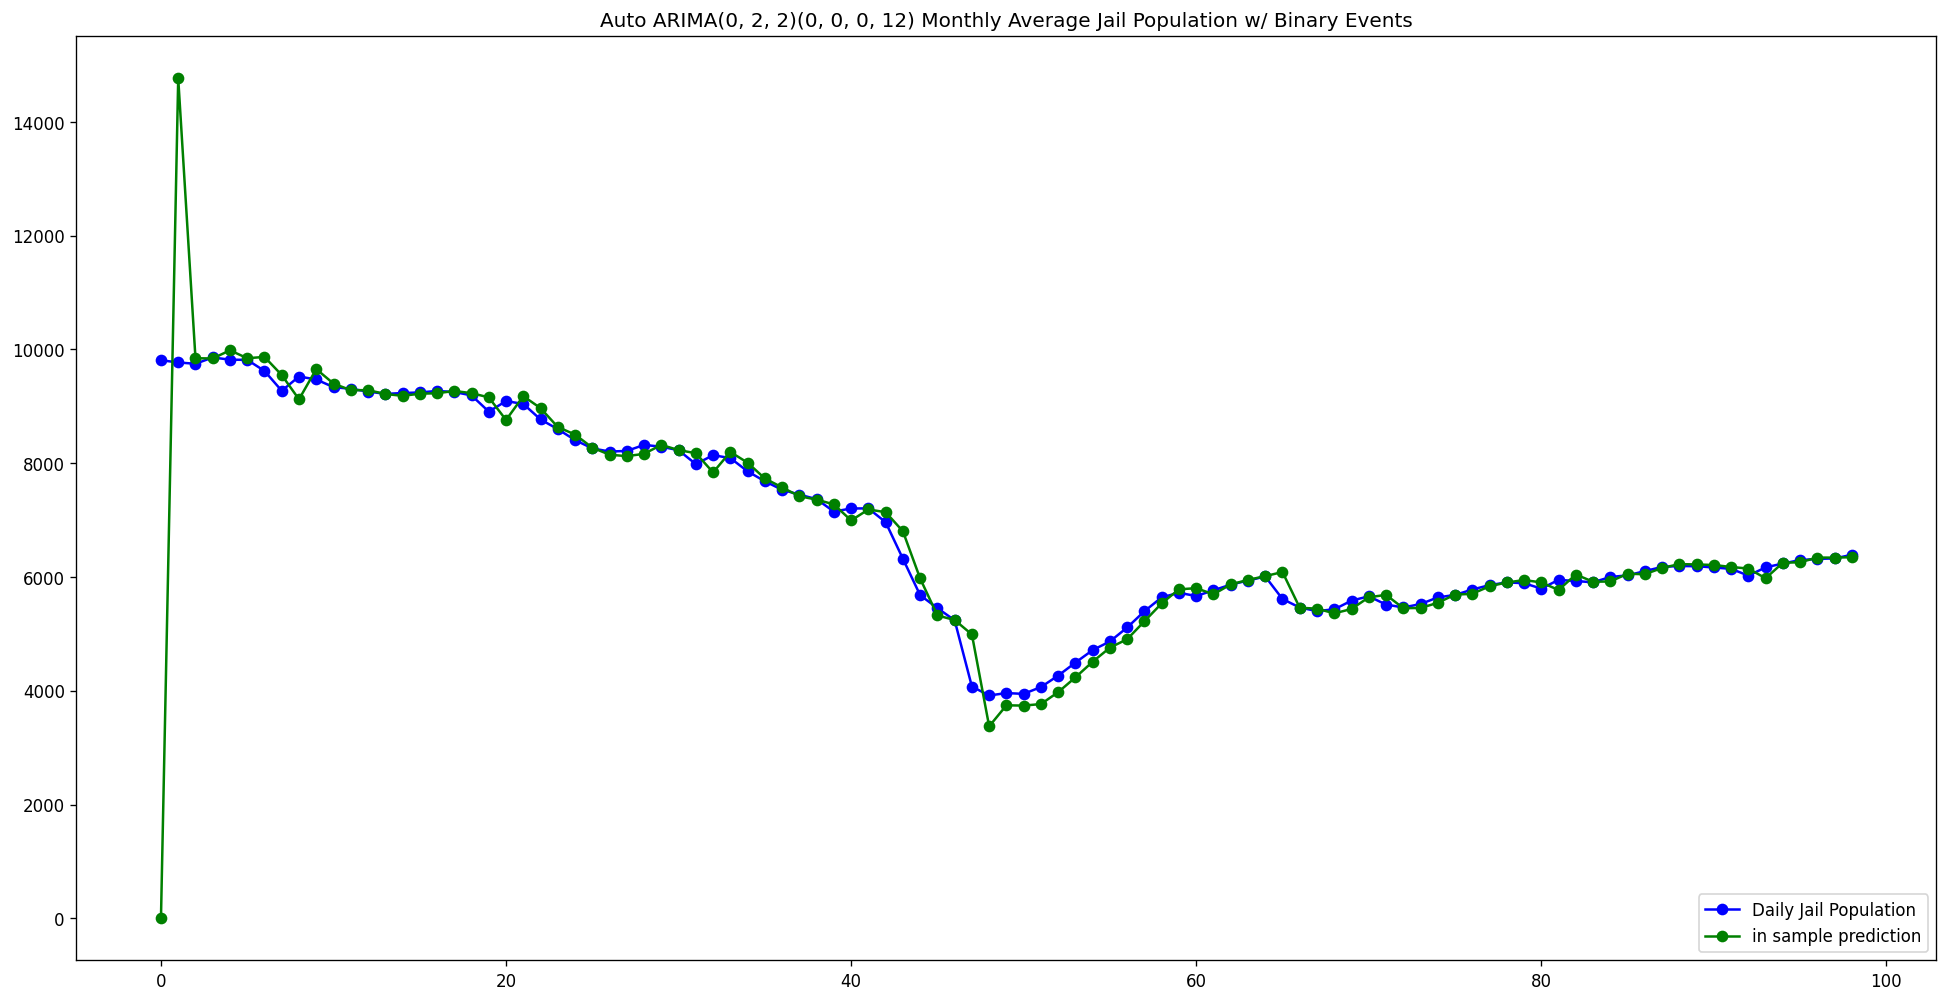

In [40]:
#now lets re-train the arima models with these exogenous variables
# Fit a simple auto_arima model
exog_vars = ['covid_event', 'less_is_more_event',
            'bail_reform_event', 'raise_the_age_17_event', 'raise_the_age_18_event',
            'de_blasio_admin', 'adams_admin', 'admission_count']
exog = monthly_pop[exog_vars]
auto_arima = pm.auto_arima(monthly_pop['ADP'],exogenous = exog,
                           d = ndiffs(monthly_pop['ADP'], test='adf'), error_action='ignore',
                           trace=True, suppress_warnings=True, maxiter=5,
                           seasonal=True, m=12)
#in sample
in_sample = auto_arima.predict_in_sample()
# Create predictions for the future, evaluate on test
# preds, conf_int = auto_arima.predict(n_periods=12, return_conf_int=True)

#plot
plt.plot(monthly_pop.index,monthly_pop['ADP'],'bo-', label = 'Daily Jail Population')
plt.plot(monthly_pop.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
# plt.plot(np.arange(len(monthly_pop),len(monthly_pop)+12), preds,'ro-',label = 'forecast')  # Forecasts
# plt.fill_between(np.arange(len(monthly_pop),len(monthly_pop)+12),
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Monthly Average Jail Population w/ Binary Events")
plt.show()

In [41]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -644.234
Date:                Wed, 10 Jul 2024   AIC                           1294.467
Time:                        20:13:58   BIC                           1302.192
Sample:                             0   HQIC                          1297.591
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5071      0.061     -8.269      0.000      -0.627      -0.387
ma.L2         -0.2819      0.097     -2.902      0.004      -0.472      -0.092
sigma2      3.464e+04   2720.574     12.733      0.0

These results are exactly the same as the other model without the exogenous variables. I am going to use the optimized parameters and the SARIMAX package to print the summary with the exogenous variables in them.

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The in sample MAE is:  243.65552505770515
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -628.222
Date:                Wed, 10 Jul 2024   AIC                           1278.444
Time:                        20:14:26   BIC                           1306.766
Sample:                             0   HQIC                          1289.896
                                 - 99                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
covid_event              139.4018     69.755      1.998      0.046       2.684     276.120
less_is_more_event       188.7251    427.782      0.4

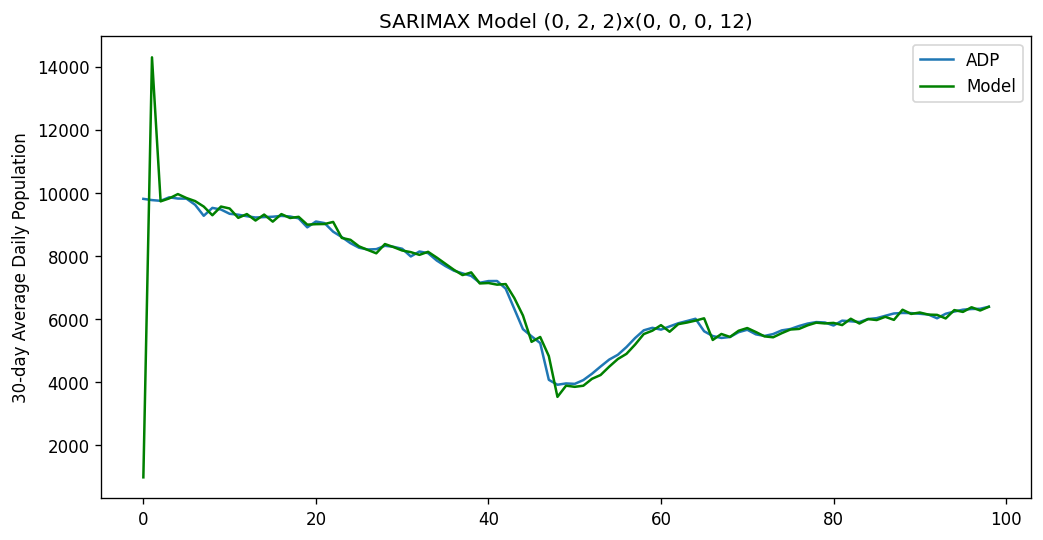

In [42]:
order = auto_arima.get_params()['order']
seasonal_order = auto_arima.get_params()['seasonal_order']

model = SARIMAX(monthly_pop['ADP'], order=order, seasonal_order=seasonal_order,exog = exog)
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # ACTUAL DATA
ax.plot(monthly_pop['ADP'].index,IS_pred,color='green',label='Model') # MODEL
plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'SARIMAX Model {order}x{seasonal_order}')
plt.legend(loc = 'upper right')
plt.show()

Based on the p-values above, it seems like little to no exogenous variables are statistically significant. I am going to re-train the model using mutually exclusive variable categories and exclude the policy intervention dates. In other words, I am only going to look at the DOC variables in combination with crime or arrest variables.

The in sample MAE is:  242.88517997057554
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -629.799
Date:                Wed, 10 Jul 2024   AIC                           1269.598
Time:                        20:14:43   BIC                           1282.472
Sample:                             0   HQIC                          1274.804
                                 - 99                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.2352      0.039      6.110      0.000       0.160       0.311
covid_event       161.2135     72.019      2.238      0.025      20.058   

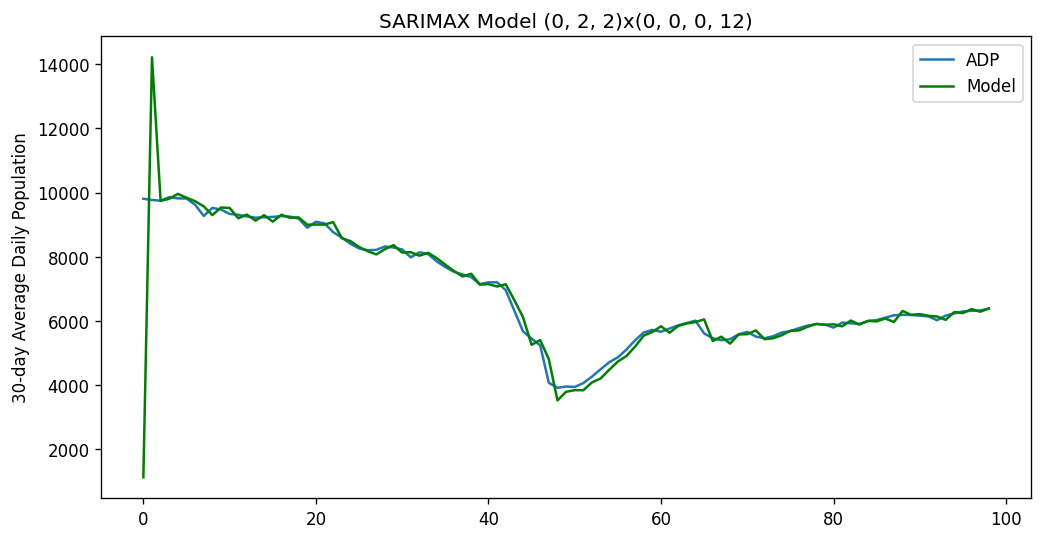

In [43]:
vars_of_interest = ['admission_count','covid_event']

model = SARIMAX(monthly_pop['ADP'], order=order, seasonal_order=seasonal_order,exog = monthly_pop[vars_of_interest])
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # ACTUAL DATA
ax.plot(monthly_pop['ADP'].index,IS_pred,color='green',label='Model') # MODEL
plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'SARIMAX Model {order}x{seasonal_order}')
plt.legend(loc = 'upper right')
plt.show()

It looks like the seasonal AR coefficient is not statistically significant. Let's remove and compare the models.

The in sample MAE is:  242.88517997057554
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -629.799
Date:                Wed, 10 Jul 2024   AIC                           1269.598
Time:                        20:15:24   BIC                           1282.472
Sample:                             0   HQIC                          1274.804
                                 - 99                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.2352      0.039      6.110      0.000       0.160       0.311
covid_event       161.2135     72.019      2.238      0.025      20.058   

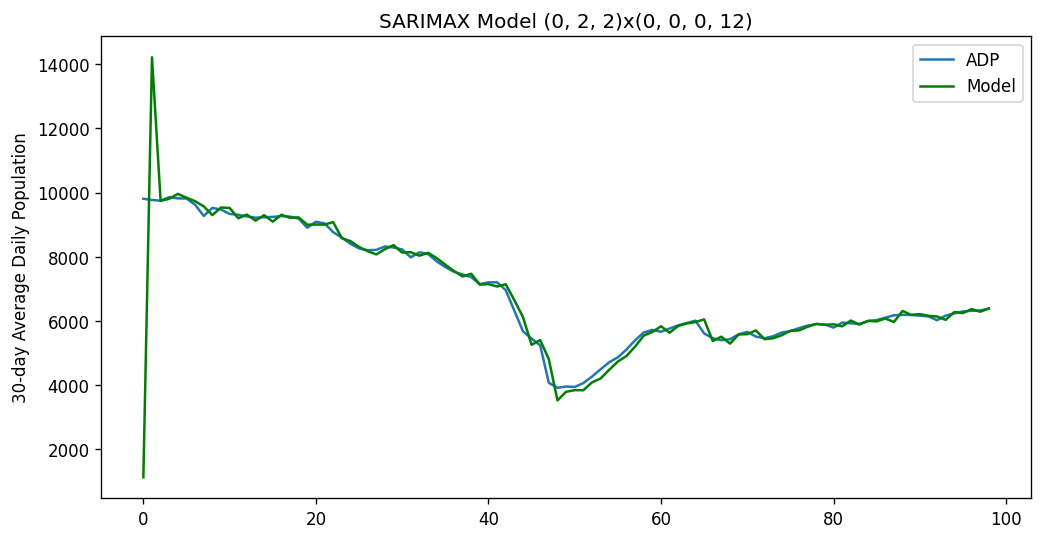

In [44]:
#exclude the season component and see how that changes the output
model = SARIMAX(monthly_pop['ADP'], order=order, seasonal_order=(0,0,0,12),exog = monthly_pop[vars_of_interest])
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # ACTUAL DATA
ax.plot(monthly_pop['ADP'].index,IS_pred,color='green',label='Model') # MODEL
plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'SARIMAX Model {order}x{(0,0,0,12)}')
plt.legend(loc = 'upper right')
plt.show()

I am going to use this model over the seasonal one due to the fact that all IVs are significant and AIC decreased. Let's use the predicted values of admission count to predict 12 future timestamps.

In [45]:
#prepare the exog predictions
exog_pred = pd.DataFrame(columns = ['covid_event','admission_count'], index=np.arange(len(monthly_pop),len(monthly_pop)+12))
#based on the executive order, covid 19 is over
exog_pred['covid_event'] = 0
exog_pred['admission_count'] = arima_dict['admission_count']['prediction']
exog_pred

,covid_event,admission_count
99,0,1931.584574
100,0,1907.803435
101,0,1927.545812
102,0,1889.319684
103,0,1888.754331
104,0,1849.001329
105,0,1854.128716
106,0,1909.776201
107,0,1923.636310
108,0,1978.792966


The in sample MAE is:  242.88468856666157
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -629.799
Date:                Wed, 10 Jul 2024   AIC                           1269.598
Time:                        20:15:36   BIC                           1282.472
Sample:                             0   HQIC                          1274.804
                                 - 99                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
covid_event       161.2089     72.021      2.238      0.025      20.050     302.368
admission_count     0.2352      0.039      6.109      0.000       0.160   

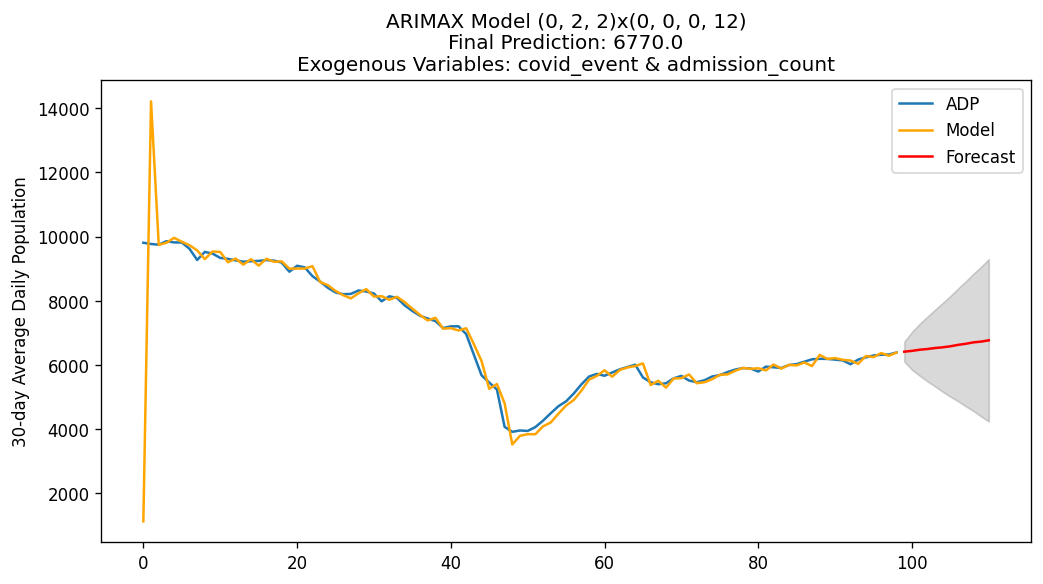

In [46]:
#predict
model = SARIMAX(monthly_pop['ADP'],
                order=order,
                seasonal_order=(0,0,0,12),
                exog = monthly_pop[['covid_event','admission_count']]
                )
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)

pred = model_fit.get_forecast(steps=12, exog = exog_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

fc_series = pd.Series(pred.summary_frame()['mean'].values)
fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # train
ax.plot(monthly_pop['ADP'].index,IS_pred,color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,fc_series,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMAX Model {order}x{(0,0,0,12)}\nFinal Prediction: {fc_series.iloc[-1].round()}\nExogenous Variables: covid_event & admission_count')
plt.legend(loc = 'upper right')
plt.savefig("../Outputs/30_day_ARIMAX_covid_admission.png", bbox_inches = 'tight')
plt.show()

In [47]:
print(fc[['mean','mean_ci_lower','mean_ci_upper']].iloc[-1])

ADP
mean             6770.219397
mean_ci_lower    4237.900321
mean_ci_upper    9302.538472
Name: 110, dtype: float64


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The in sample MAE is:  243.10317939097146
                                      SARIMAX Results                                      
Dep. Variable:                                 ADP   No. Observations:                   99
Model:             SARIMAX(0, 2, 2)x(1, 0, [], 12)   Log Likelihood                -629.760
Date:                             Wed, 10 Jul 2024   AIC                           1271.519
Time:                                     20:16:15   BIC                           1286.968
Sample:                                          0   HQIC                          1277.766
                                              - 99                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
covid_event       160.2534     71.655      2.236      

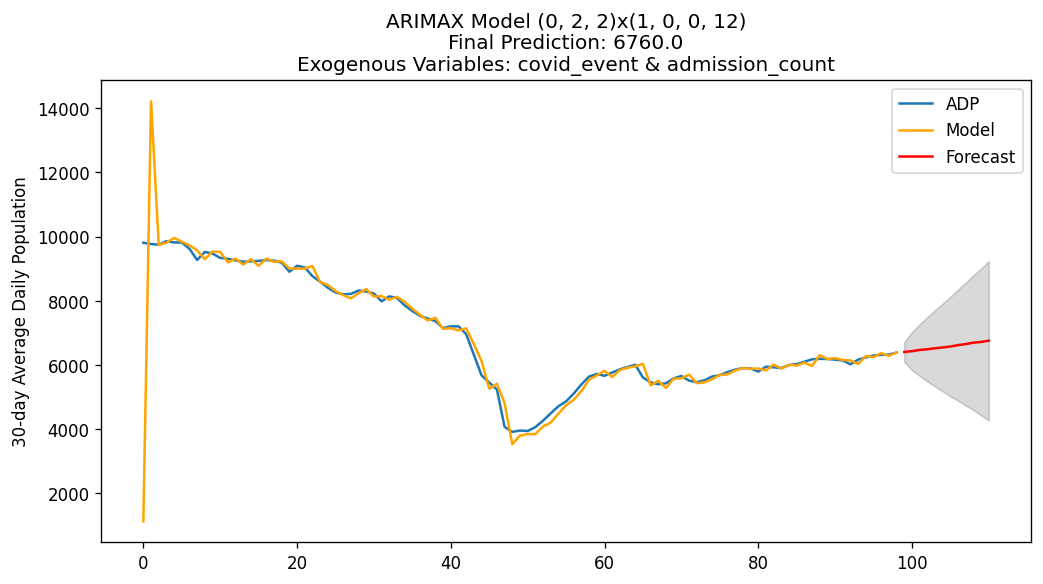

In [48]:
#predict
model = SARIMAX(monthly_pop['ADP'],
                order=order,
                seasonal_order=(1,0,0,12),
                exog = monthly_pop[['covid_event','admission_count']]
                )
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)

pred = model_fit.get_forecast(steps=12, exog = exog_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

fc_series = pd.Series(pred.summary_frame()['mean'].values)
fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # train
ax.plot(monthly_pop['ADP'].index,IS_pred,color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,fc_series,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMAX Model {order}x{(1,0,0,12)}\nFinal Prediction: {fc_series.iloc[-1].round()}\nExogenous Variables: covid_event & admission_count')
plt.legend(loc = 'upper right')
plt.savefig("../Outputs/30_day_SARIMAX_covid_admission.png", bbox_inches = 'tight')
plt.show()

In [49]:
print(fc[['mean','mean_ci_lower','mean_ci_upper']].iloc[-1])

ADP
mean             6759.727090
mean_ci_lower    4279.636025
mean_ci_upper    9239.818155
Name: 110, dtype: float64


The in sample MAE is:  267.4856254373011
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -644.206
Date:                Wed, 10 Jul 2024   AIC                           1294.413
Time:                        20:16:27   BIC                           1302.137
Sample:                             0   HQIC                          1297.536
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5083      0.060     -8.519      0.000      -0.625      -0.391
ma.L2         -0.2852      0.094     -3.023      0.003      -0.470      -0.100
sigma2     

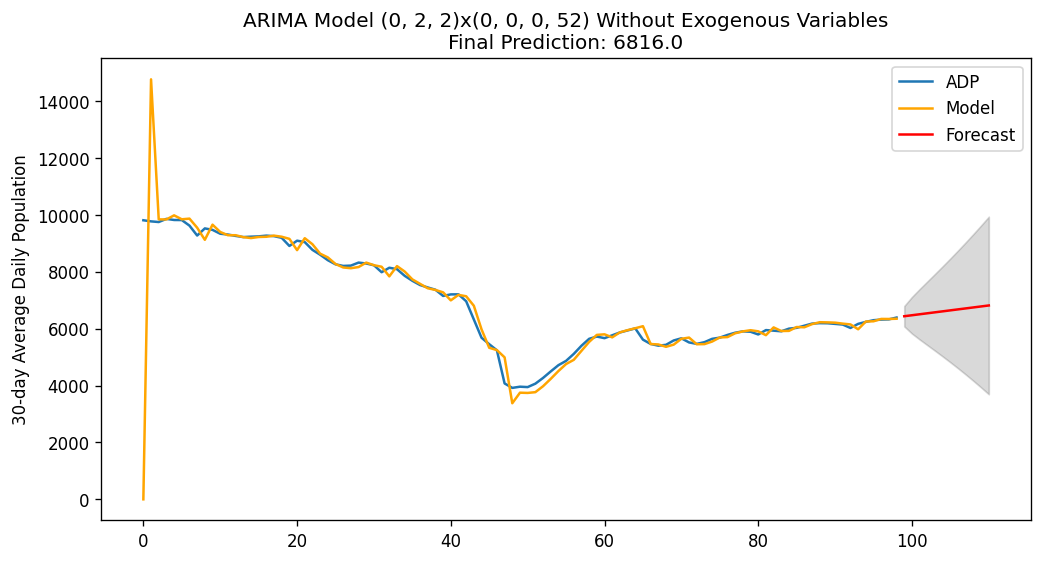

In [50]:
# run model without exogenous variables
#predict
model = SARIMAX(monthly_pop['ADP'],
                order=order,
                seasonal_order=(0,0,0,12)
                )
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)

pred = model_fit.get_forecast(steps=12)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

fc_series = pd.Series(pred.summary_frame()['mean'].values)
fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # train
ax.plot(monthly_pop['ADP'].index,IS_pred,color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,fc_series,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMA Model {order}x{(0,0,0,52)} Without Exogenous Variables\nFinal Prediction: {fc_series.iloc[-1].round()}')
plt.legend(loc = 'upper right')
plt.savefig("../Outputs/30_day_ARIMA_no_exog.png", bbox_inches = 'tight')
plt.show()

In [51]:
print(fc[['mean','mean_ci_lower','mean_ci_upper']].iloc[-1])

ADP
mean             6815.798421
mean_ci_lower    3693.985151
mean_ci_upper    9937.611691
Name: 110, dtype: float64


The in sample MAE is:  267.24486127165494
                                      SARIMAX Results                                      
Dep. Variable:                                 ADP   No. Observations:                   99
Model:             SARIMAX(0, 2, 2)x(1, 0, [], 12)   Log Likelihood                -643.362
Date:                             Wed, 10 Jul 2024   AIC                           1294.724
Time:                                     20:16:43   BIC                           1305.023
Sample:                                          0   HQIC                          1298.888
                                              - 99                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4735      0.053     -8.851      0.000      -0.5

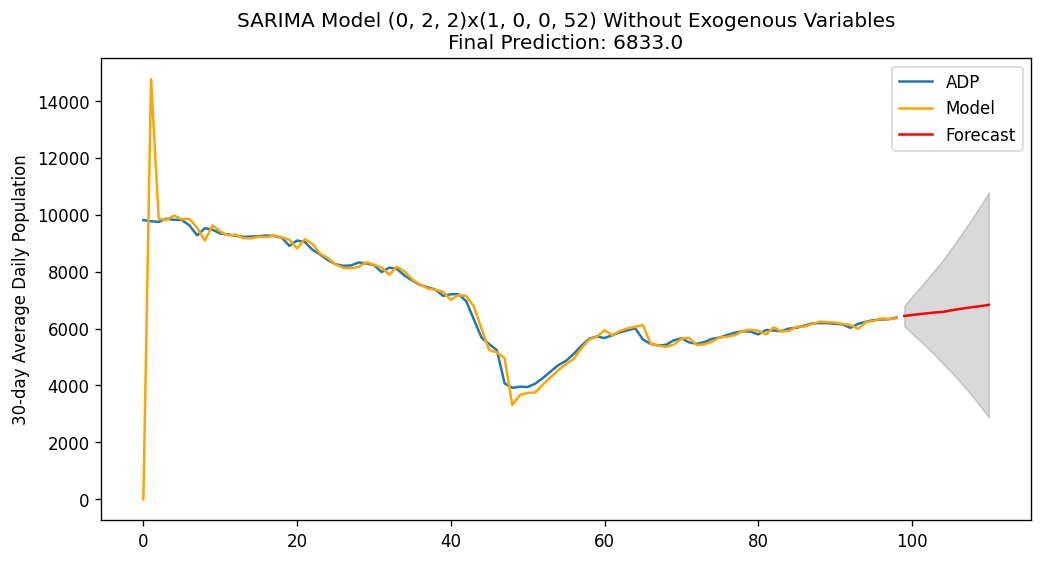

In [52]:
# run model without exogenous variables
#predict
model = SARIMAX(monthly_pop['ADP'],
                order=order,
                seasonal_order=(1,0,0,12)
                )
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(monthly_pop['ADP'], IS_pred)

pred = model_fit.get_forecast(steps=12)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

fc_series = pd.Series(pred.summary_frame()['mean'].values)
fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop['ADP'].index,monthly_pop['ADP'],label='ADP') # train
ax.plot(monthly_pop['ADP'].index,IS_pred,color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,fc_series,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'SARIMA Model {order}x{(1,0,0,52)} Without Exogenous Variables\nFinal Prediction: {fc_series.iloc[-1].round()}')
plt.legend(loc = 'upper right')
plt.savefig("../Outputs/30_day_SARIMA_no_exog.png", bbox_inches = 'tight')
plt.show()

In [53]:
print(fc[['mean','mean_ci_lower','mean_ci_upper']].iloc[-1])

ADP
mean              6833.080512
mean_ci_lower     2882.097325
mean_ci_upper    10784.063698
Name: 110, dtype: float64


## Using Log of the TS signal to ensure non-negativaty

I am going to also use an auto_arima to optimize the coefficients for the log of the monthly/30-day jail population. I will see if the output and performance are any different than that of the above models. 

I will do so by applying a log transformation before modeling, and then transform the predictions back to the original scale. This can ensure the predictions are non-negative.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=-372.463, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-355.433, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-363.883, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-374.604, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-375.420, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-374.880, Time=0.16 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-372.698, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-375.467, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-374.023, Time=0.21 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=-373.962, Time=0.14 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-372.027, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-363.742, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=-377.502, Time=0.05 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-376.608, Time=0.31 sec
 ARIMA(2,2,1)(0,0,1

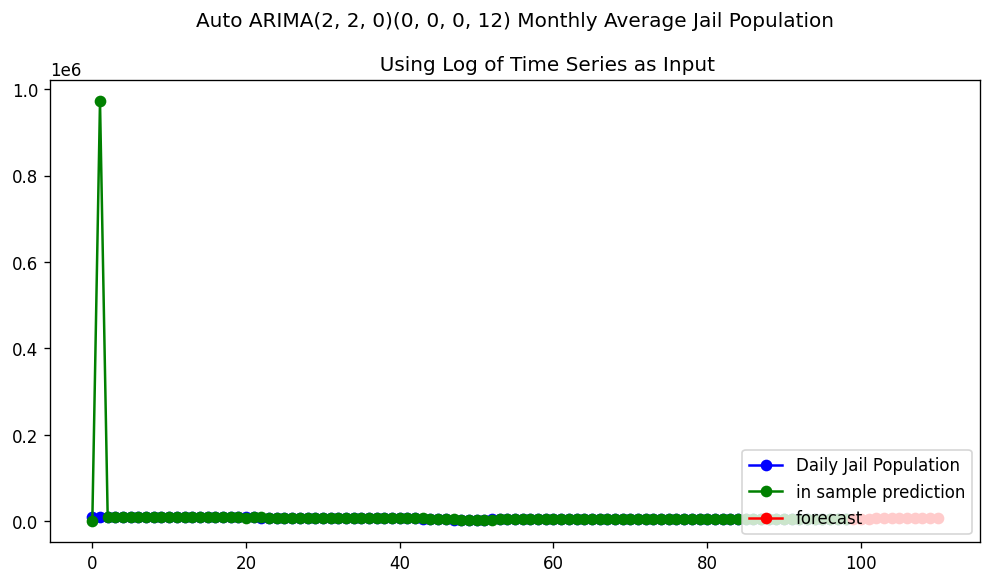

In [54]:
# Fit a simple auto_arima model
y_log = np.log(monthly_pop['ADP'])
auto_arima = pm.auto_arima(y_log, error_action='ignore', trace=True,
                      suppress_warnings=True, d = ndiffs(y_log, test='adf'), maxiter=5,
                      seasonal=True, m=12)
#in sample
in_sample_log = auto_arima.predict_in_sample()
in_sample = np.exp(in_sample_log)
# Create predictions for the future, evaluate on test
preds_log, conf_int_log = auto_arima.predict(n_periods=12, return_conf_int=True)
preds = np.exp(preds_log)
conf_int = np.exp(conf_int_log)

#plot
plt.plot(monthly_pop.index,monthly_pop['ADP'],'bo-', label = 'Daily Jail Population')
plt.plot(monthly_pop.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(monthly_pop),len(monthly_pop)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(monthly_pop),len(monthly_pop)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"""Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Monthly Average Jail Population\n
          Using Log of Time Series as Input""")
plt.show()

There seems to be a massive outlier due to the ARIMA coefficients and taking the logarithm. Lets get ride of the first two in sample predictions and replot for a better scale.

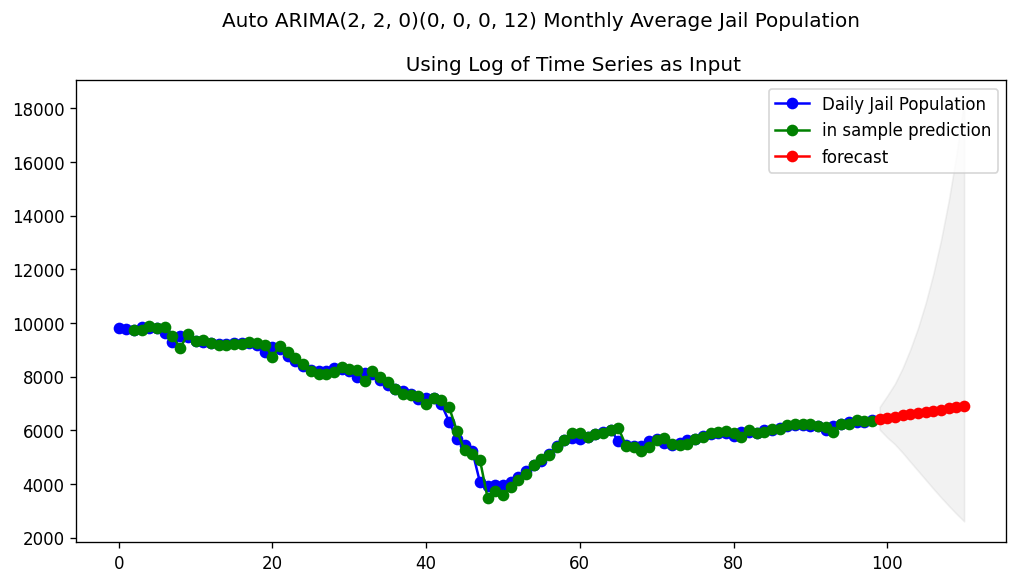

In [55]:
#plot
plt.plot(monthly_pop.index,monthly_pop['ADP'],'bo-', label = 'Daily Jail Population')
plt.plot(monthly_pop.iloc[2:].index, in_sample.iloc[2:],'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(monthly_pop),len(monthly_pop)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(monthly_pop),len(monthly_pop)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'best')
plt.title(f"""Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Monthly Average Jail Population\n
          Using Log of Time Series as Input""")
plt.show()

In [56]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(2, 2, 0)   Log Likelihood                 192.246
Date:                Wed, 10 Jul 2024   AIC                           -378.493
Time:                        20:16:58   BIC                           -370.769
Sample:                             0   HQIC                          -375.369
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4456      0.039    -11.338      0.000      -0.523      -0.369
ar.L2         -0.4000      0.043     -9.309      0.000      -0.484      -0.316
sigma2         0.0011   6.81e-05     16.170      0.0

In [57]:
preds.iloc[-1]

6904.2206253687755

In [58]:
conf_int[-1,:]

array([ 2610.87532745, 18257.5789593 ])

Note that the auto_arima method outputed the same coefficients with the log signal as the normal signal. However, the AIC is much different. The AIC value can be negative or positive. It is calculated as:

$AIC = 2k − 2ln(L)$

where $k$ is the number of parameters in the model and $L$ is the maximum value of the likelihood function for the model. Since the logarithm of a likelihood can be a negative value (if the likelihood is a small fraction), the AIC can be negative if the fit of the model is sufficiently good and the likelihood is high enough.

The absolute value of AIC is not as important as the relative difference between AIC values for different models. When comparing models, the model with the lower AIC is preferred. A negative AIC simply indicates a better model fit with a higher likelihood value.

If you observe a negative AIC, it means the model fits the data well. It doesn’t imply any issue; instead, it indicates that the maximum log-likelihood for your model is large (less negative or more positive).

In summary, a negative AIC indicates that the model has a high likelihood (good fit) relative to the complexity (number of parameters) of the model. The key use of AIC is in comparing different models: the model with the lowest AIC is generally preferred.

Now I am going to exclude the seasonal component because it has proven to have little statistical significance and using the log of our continuous exogenous variables to see if anything has changed.

In [59]:
#import the dictionary and use the key to get the order and seasonal order 
# Opening JSON file
with open("../Data/30_day_exog_ARIMA_models_log.json") as json_file:
    arima_log_dict = json.load(json_file)

print(arima_log_dict['admission_count'])

{'order': [1, 1, 0], 'seasonal_order': [1, 0, 0, 12], 'IS_MEA': 218.26, 'adjusted y': [4800.0, 4857.0, 4798.0, 4687.0, 4590.0, 4669.0, 4124.0, 4008.0, 4869.0, 4469.0, 4842.0, 4815.0, 4740.0, 4430.0, 4659.0, 4331.0, 4333.0, 4229.0, 4084.0, 3394.0, 4112.0, 3618.0, 3735.0, 3813.0, 3544.0, 3579.0, 3623.0, 3305.0, 3311.0, 3463.0, 3132.0, 2712.0, 3483.0, 3367.0, 3069.0, 3096.0, 3025.0, 2777.0, 3035.0, 2589.0, 2881.0, 2519.0, 2210.0, 1579.0, 1949.0, 1887.0, 1318.0, 647.0, 1092.0, 819.0, 934.0, 1162.0, 1530.0, 1532.0, 1312.0, 1199.0, 1298.0, 1321.0, 1474.0, 1211.0, 1384.0, 1527.0, 1449.0, 1487.0, 1415.0, 1298.0, 1246.0, 1302.0, 1163.0, 1528.0, 1547.0, 1553.0, 1664.0, 1655.0, 1689.0, 1712.0, 1802.0, 1751.0, 1790.0, 1607.0, 1513.0, 1840.0, 1770.0, 1708.0, 2015.0, 1901.0, 1938.0, 1888.0, 1801.0, 1860.0, 1805.0, 1740.0, 1639.0, 1873.0, 1938.0, 1954.0, 2031.0, 1909.0, 1914.061666372813], 'prediction': [1916.0905834158127, 1905.799484995871, 1906.4874605847128, 1897.1384902487239, 1883.453554848552,

In [60]:
#duplicate the monthly pop df and make it all log
monthly_pop_log = monthly_pop.copy()
monthly_pop_log['ln_ADP'] = np.log(monthly_pop_log['ADP'])
#add column for admission count
monthly_pop_log['ln_admission_count'] = np.log(arima_log_dict['admission_count']['adjusted y'])
monthly_pop_log.head()

,End Date,ADP,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin,Start Date,admission_count,ln_ADP,ln_admission_count
0,2016-06-21,9811.0,0,0,0,0,0,1,0,2016-05-23,4800.0,9.191259,8.476371
1,2016-07-21,9772.0,0,0,0,0,0,1,0,2016-06-22,4857.0,9.187276,8.488176
2,2016-08-20,9749.0,0,0,0,0,0,1,0,2016-07-22,4798.0,9.184920,8.475954
3,2016-09-19,9860.0,0,0,0,0,0,1,0,2016-08-21,4687.0,9.196241,8.452548
4,2016-10-19,9821.0,0,0,0,0,0,1,0,2016-09-20,4590.0,9.192278,8.431635


In [61]:
#prepare the exog predictions
exog_pred_log = pd.DataFrame(columns = ['ln_admission_count','covid_event'], index=np.arange(len(monthly_pop_log),len(monthly_pop_log)+12))
#based on the executive order, covid 19 is over
exog_pred_log['ln_admission_count'] = np.log(arima_log_dict['admission_count']['prediction'])
exog_pred_log['covid_event'] = 0
exog_pred_log

,ln_admission_count,covid_event
99,7.558042,0
100,7.552657,0
101,7.553018,0
102,7.548102,0
103,7.540862,0
104,7.529462,0
105,7.554562,0
106,7.554609,0
107,7.553672,0
108,7.556798,0


The in sample MAE is:  111.77801595138014
                               SARIMAX Results                                
Dep. Variable:                 ln_ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 210.178
Date:                Wed, 10 Jul 2024   AIC                           -410.356
Time:                        20:18:16   BIC                           -397.482
Sample:                             0   HQIC                          -405.150
                                 - 99                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ln_admission_count     0.0862      0.010      8.286      0.000       0.066       0.107
covid_event            0.0237      0.014      1.729      0.084   

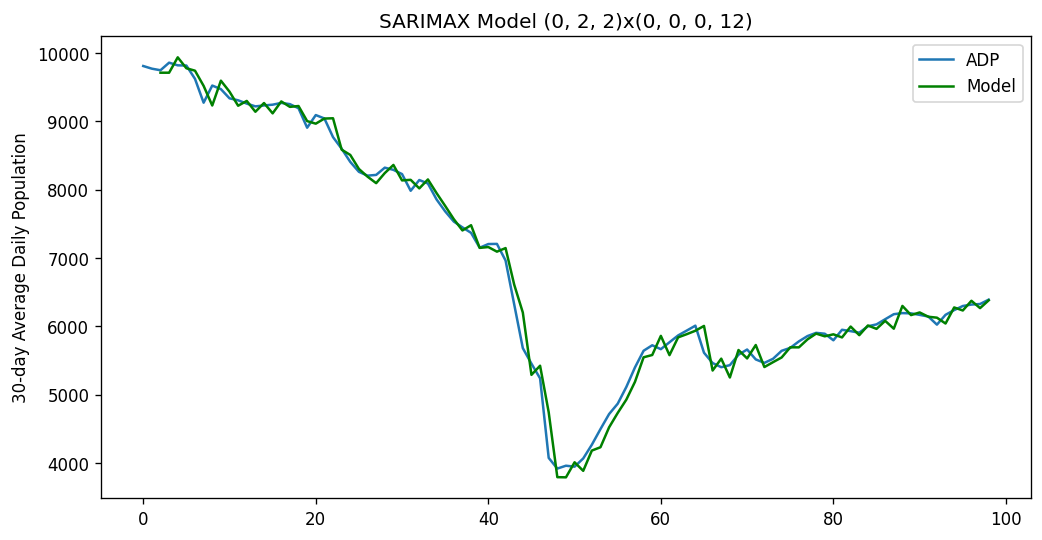

In [62]:
vars_of_interest = ['ln_admission_count','covid_event']

model = SARIMAX(monthly_pop_log['ln_ADP'], order=order, seasonal_order=seasonal_order,exog = monthly_pop_log[vars_of_interest])
model_fit = model.fit()
IS_pred_log = model_fit.predict()
IS_pred = np.exp(IS_pred_log)
IS_mae = mean_absolute_error(monthly_pop_log['ADP'].iloc[2:], IS_pred.iloc[2:])
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_pop_log['ADP'].index,monthly_pop_log['ADP'],label='ADP') # ACTUAL DATA
ax.plot(monthly_pop_log['ADP'].iloc[2:].index,IS_pred.iloc[2:],color='green',label='Model') # MODEL
plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'SARIMAX Model {order}x{seasonal_order}')
plt.legend(loc = 'upper right')
plt.show()

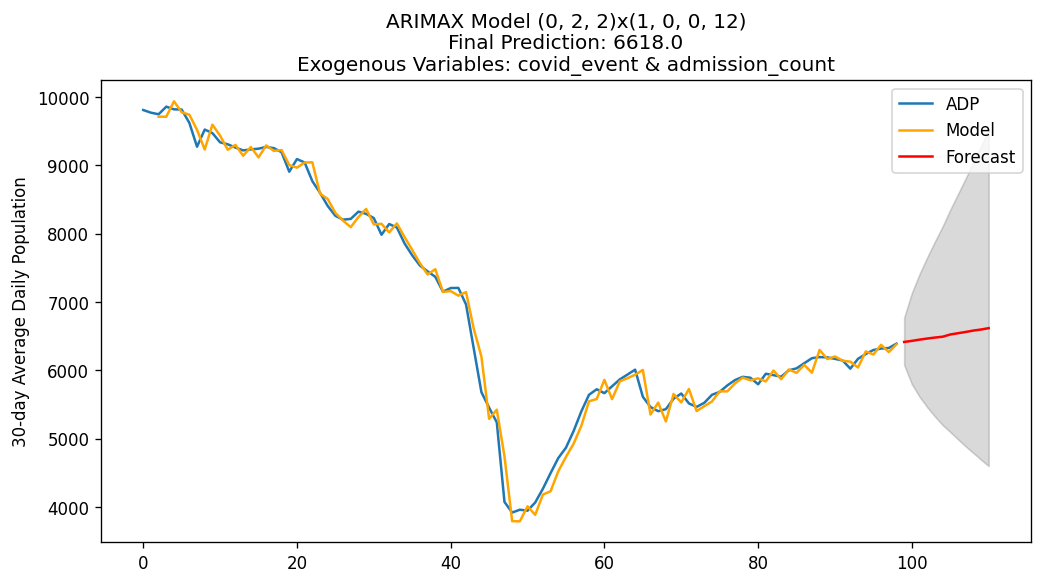

In [63]:
#predict
forecast_log = model_fit.get_forecast(steps=12, exog = exog_pred_log)
y_forecast_log = forecast_log.predicted_mean
y_forecast = np.exp(y_forecast_log)
conf_int_log = forecast_log.conf_int()
conf_int = np.exp(conf_int_log)
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop_log['ADP'].index,monthly_pop_log['ADP'],label='ADP') # train
ax.plot(monthly_pop_log['ADP'].iloc[2:].index,IS_pred.iloc[2:],color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,y_forecast,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMAX Model {order}x{(1,0,0,12)}\nFinal Prediction: {y_forecast.iloc[-1].round()}\nExogenous Variables: covid_event & admission_count')
plt.legend(loc = 'upper right')
plt.savefig("../Outputs/30_day_SARIMAX_covid_admission_log.png", bbox_inches = 'tight')
plt.show()

In [64]:
print(y_forecast.iloc[-1],conf_int.iloc[-1].values)

6617.709655854576 [4599.64699886 9521.18306037]


In [65]:
#compute additional CI from the standard error outputed by the forecast
se_log = forecast_log.summary_frame()['mean_se']
#critical values for each CI
z_90 = 1.645
z_80 = 1.28

conf_int_90_log = np.column_stack([y_forecast_log - z_90 * se_log, y_forecast_log + z_90 * se_log])
conf_int_80_log = np.column_stack([y_forecast_log - z_80 * se_log, y_forecast_log + z_80 * se_log])

conf_int_90 = np.exp(conf_int_90_log)
conf_int_80 = np.exp(conf_int_80_log)
    

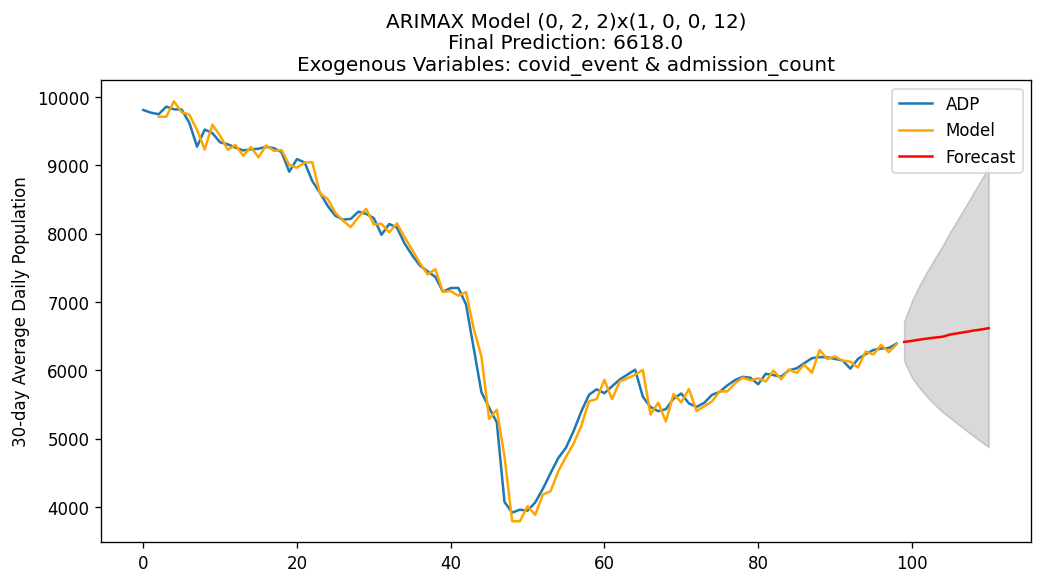

In [66]:
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop_log['ADP'].index,monthly_pop_log['ADP'],label='ADP') # train
ax.plot(monthly_pop_log['ADP'].iloc[2:].index,IS_pred.iloc[2:],color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,y_forecast,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, conf_int_90[:,0], conf_int_90[:,1], color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMAX Model {order}x{(1,0,0,12)}\nFinal Prediction: {y_forecast.iloc[-1].round()}\nExogenous Variables: covid_event & admission_count')
plt.legend(loc = 'upper right')
plt.show()

In [67]:
print(conf_int_90)

[[6132.69675493 6711.9515961 ]
 [5895.74113772 7015.23847129]
 [5740.63180028 7246.55767869]
 [5611.08303628 7450.07130527]
 [5495.65958307 7640.62818423]
 [5387.96257943 7822.66390678]
 [5303.66559287 8027.22133931]
 [5212.50616637 8214.51422767]
 [5124.54579305 8402.07568908]
 [5041.21565206 8594.57050247]
 [4956.21995393 8782.93128367]
 [4876.54486979 8980.5553437 ]]


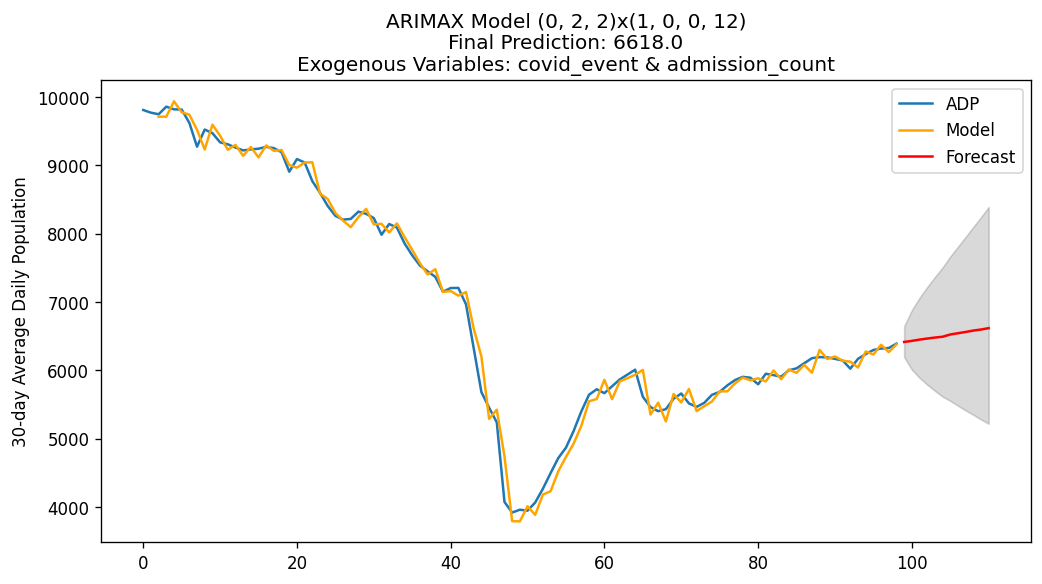

In [68]:
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop_log['ADP'].index,monthly_pop_log['ADP'],label='ADP') # train
ax.plot(monthly_pop_log['ADP'].iloc[2:].index,IS_pred.iloc[2:],color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,y_forecast,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, conf_int_80[:,0], conf_int_80[:,1], color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMAX Model {order}x{(1,0,0,12)}\nFinal Prediction: {y_forecast.iloc[-1].round()}\nExogenous Variables: covid_event & admission_count')
plt.legend(loc = 'upper right')
plt.show()

In [69]:
print(conf_int_80)

[[6194.41260471 6645.07942873]
 [6010.56079094 6881.22647532]
 [5890.93116994 7061.6712796 ]
 [5790.35526137 7219.41346138]
 [5700.28650752 7366.34754164]
 [5615.51330276 7505.67546167]
 [5553.21552646 7666.49474   ]
 [5482.28479634 7810.28488234]
 [5413.50000975 7953.60146814]
 [5348.59068901 8100.65414591]
 [5281.02825112 8242.73933261]
 [5218.34883264 8392.32533004]]


Now, lets re-train without the seasonal component.

The in sample MAE is:  111.77801595138014
                               SARIMAX Results                                
Dep. Variable:                 ln_ADP   No. Observations:                   99
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 210.178
Date:                Wed, 10 Jul 2024   AIC                           -410.356
Time:                        20:19:19   BIC                           -397.482
Sample:                             0   HQIC                          -405.150
                                 - 99                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ln_admission_count     0.0862      0.010      8.286      0.000       0.066       0.107
covid_event            0.0237      0.014      1.729      0.084   

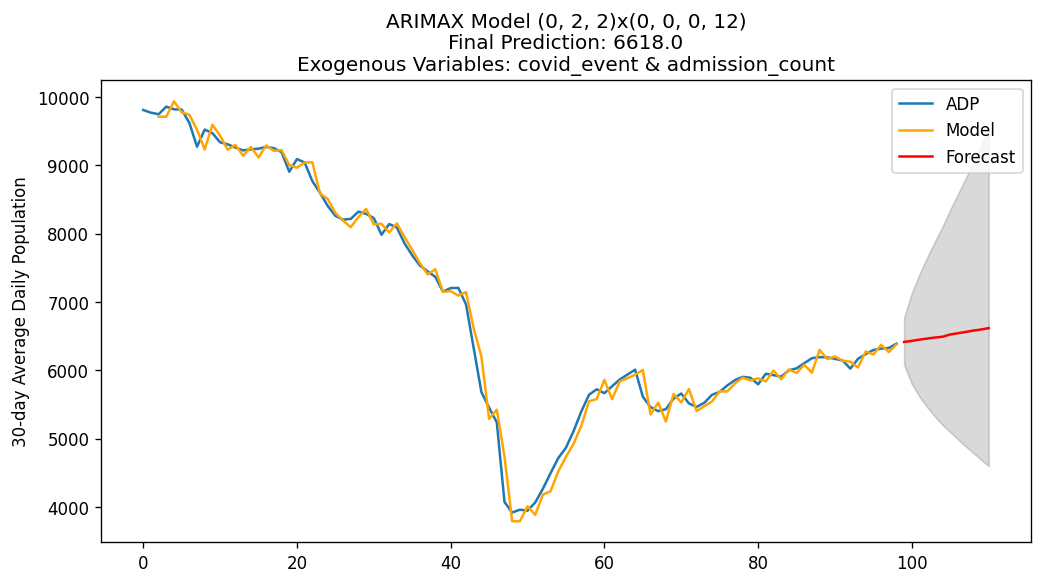

In [70]:
model = SARIMAX(monthly_pop_log['ln_ADP'], order=order, seasonal_order=(0,0,0,12),exog = monthly_pop_log[vars_of_interest])
model_fit = model.fit()
IS_pred_log = model_fit.predict()
IS_pred = np.exp(IS_pred_log)
IS_mae = mean_absolute_error(monthly_pop_log['ADP'].iloc[2:], IS_pred.iloc[2:])
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())


#predict
forecast_log = model_fit.get_forecast(steps=12, exog = exog_pred_log)
y_forecast_log = forecast_log.predicted_mean
y_forecast = np.exp(y_forecast_log)
conf_int_log = forecast_log.conf_int()
conf_int = np.exp(conf_int_log)
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()

ax.plot(monthly_pop_log['ADP'].index,monthly_pop_log['ADP'],label='ADP') # train
ax.plot(monthly_pop_log['ADP'].iloc[2:].index,IS_pred.iloc[2:],color='orange',label='Model') # in-sample get rid of first point for scale
ax.plot(fc.index,y_forecast,color='red',label='Forecast') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('30-day Average Daily Population')
plt.title(f'ARIMAX Model {order}x{(0,0,0,12)}\nFinal Prediction: {y_forecast.iloc[-1].round()}\nExogenous Variables: covid_event & admission_count')
plt.legend(loc = 'upper right')
plt.savefig("../Outputs/30_day_ARIMAX_covid_admission_log.png", bbox_inches = 'tight')
plt.show()

In [71]:
print(y_forecast.iloc[-1],conf_int.iloc[-1].values)

6617.709655854576 [4599.64699886 9521.18306037]


Based on the outputs of the monthly models, the exogenous variables that are statistically significant in predicting ADP is the covid 19 intervention event and admission counts. The performance and prediction outputs of the two models are below. We also include the outputs of the same models without exogenous variables to compare performance.

Sampling|ARIMA order|Exogenous Variables|Final Prediction|95% CI Lower Bound|95% CI Upper Bound|$\alpha <= 0.05$|IS MAE|AIC|
|-------|-----------|-------------------|----------------|------------------|------------------|----------------|------|---|
|30-Day|(2,2,0)(1,0,0,12)|admission_count, covid_event|6,663.92|1,866.15|11,461.68|No|231.57|1,257.50|
|30-Day|(2,2,0)(0,0,0,12)|admission_count, covid_event|6,661.43|1,863.59|11,459.27|Yes|231.63|1,255.56|
|30-Day|(2,2,0)(1,0,0,12)|None|6,631.63|1,455.1|11,808.18|Yes|264.35|1,271.02|
|30-Day|(2,2,0)(0,0,0,12)|None|6,650.07|1,282.97|12,017.16|Yes|266.82|1,275.37|
|Log 30-Day|(2,2,0)(1,0,0,12)|admission_count, covid_event|6,587.45|2,857.94|15,183.80|No|110.43|-399.30|
|Log 30-Day|(2,2,0)(0,0,0,12)|admission_count, covid_event|6,592.92|2,857.73|15,210.16|Yes|109.45|-401.22|

*IVs are significant with $\alpha <= 0.1$

Based on the results above, the models  using the logarithm of ADP and it's exogenous variables and no seasonal component perform better than all other models. This is due to the smaller in sample mean absolute error metrics AND the smaller AIC values.